<a href="https://colab.research.google.com/github/Shree-Mh/Project/blob/main/ansi2025/LAB_combined_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab Part - 1


##Basic Data Understanding and Pre-Processing



```
# This is formatted as code
```


What is an Orthomosaic?

 An orthomosaic is a geometrically corrected aerial image created by stitching together hundreds or thousands of drone or satellite images into one single map-accurate image.

Unlike normal photos:


*   Distortions caused by camera angle, terrain height, and perspective are corrected
*  Every pixel corresponds to a real-world location
*   The image can be used like a map (measure distance, area, change over time)

Basically, An orthomosaic is a photo map of the Earth that is spatially accurate.

For out study we choose a specific area of Hanumannagar Kankalini Municipality in Nepal's Saptari District . The image of the pre flood and post flood orthomosiac is as shown

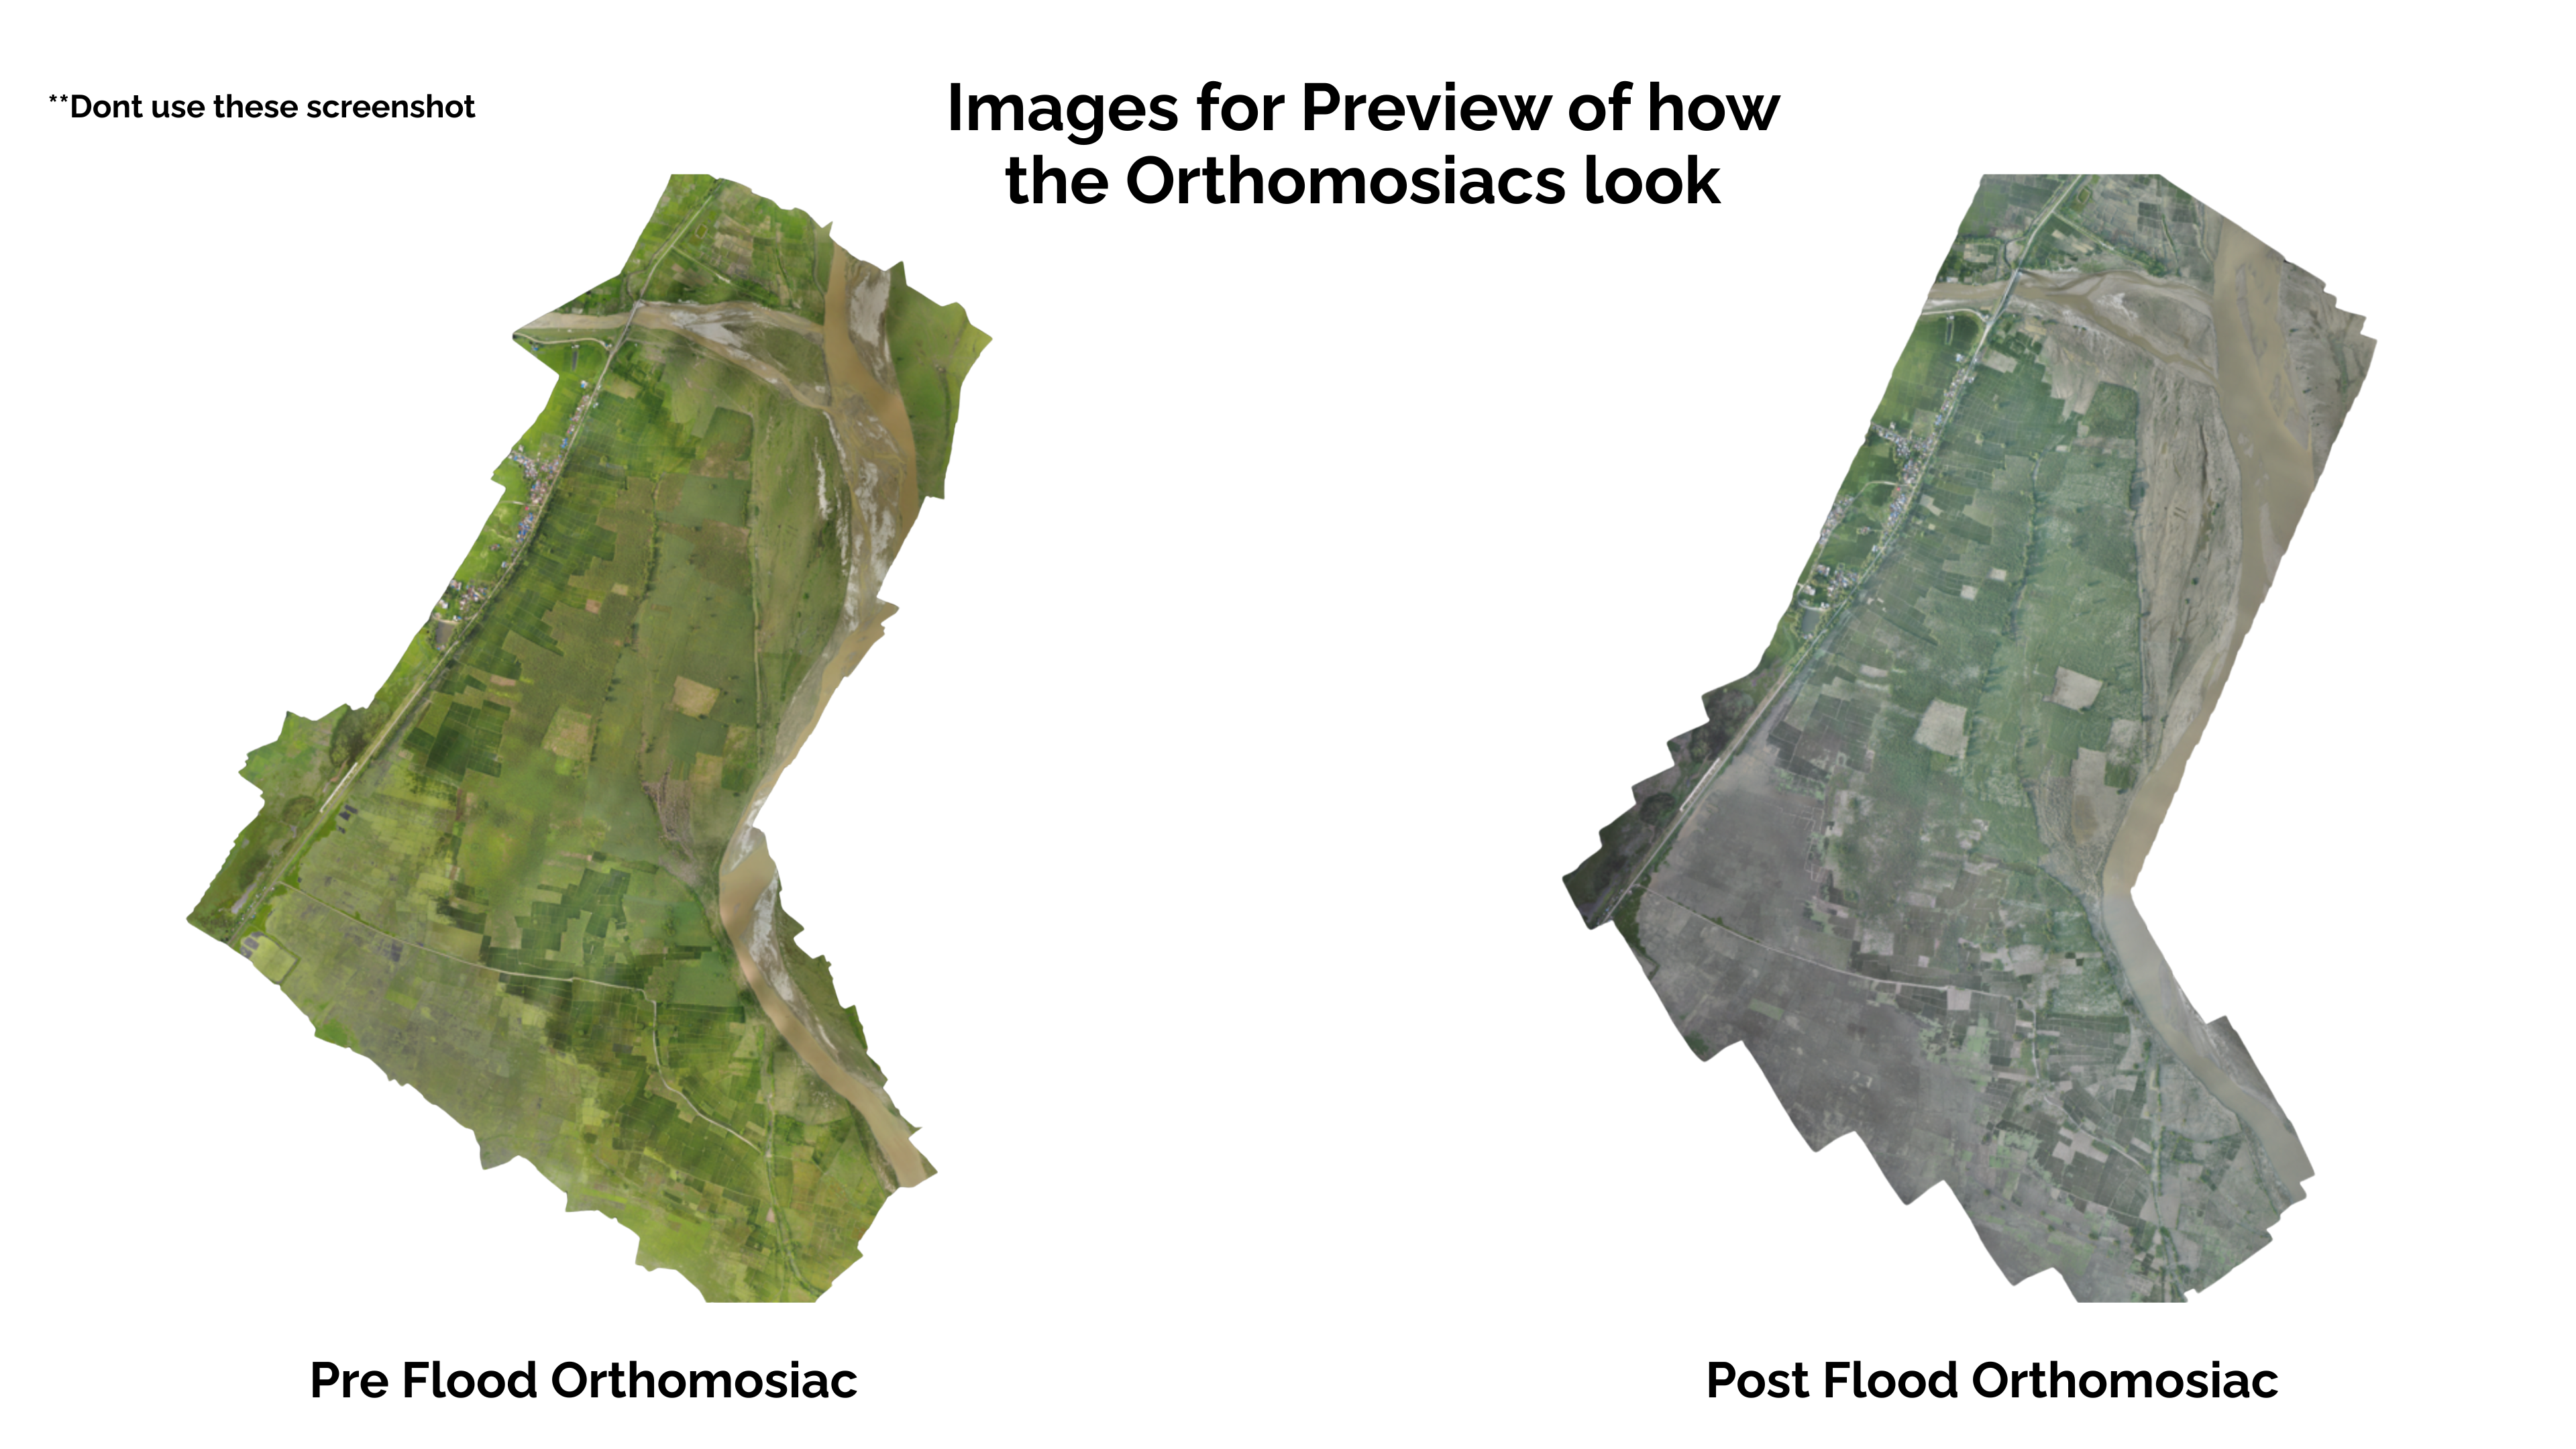

These orthomosiac are

*   Very large in size (GBs)
*   High resolution (e.g., 2–5 cm per pixel)
*   Too big to fit into memory
*   Not suitable as direct input to AI models

For example:

One orthomosaic can be 20,000 × 20,000 pixels

Deep learning models typically expect images like 256 × 256 or 512 × 512







📸 Understanding the Data & Approach
What you're working with:

The images provided are TIFF (Tagged Image File Format) orthomosaics—georeferenced aerial images stitched together from hundreds of drone photos. Unlike regular JPEGs or PNGs you might work with daily, these are massive, high-resolution files often spanning several gigabytes. A single orthomosaic can cover entire valleys with centimeter-level detail, capturing every road, field, building, and water body.

**Why TIFF?** This format preserves geospatial metadata (coordinates, projection systems, pixel resolution) and supports lossless compression, making it the standard for GIS and remote sensing work. Each pixel in these images corresponds to a real-world location with latitude/longitude coordinates—critical for generating accurate area measurements and coordinates.

The challenge of scale:

You cannot simply load these images into memory and run a basic script. A full orthomosaic might be 50,000 x 100,000 pixels or larger, requiring smart handling:


*   tiling the image into smaller patches
*   processing in batches
*   using libraries like rasterio and gdal designed for geospatial rasters
*   Even viewing the full image requires tools like QGIS or specialized viewers.


Lets do hands on with tiling now. Currently we use simple snall tile of 1024 × 1024 tif for quick results and basic understanding.

In [ ]:
## Download the image to test the tiling

import gdown

folder_url = "https://drive.google.com/drive/folders/1QhlIs2EGMfwNkHmNxgJH1EOHnoI0NlFD?usp=drive_link"

gdown.download_folder(folder_url, quiet=False, use_cookies=False)

In [ ]:
# Install required packages
!pip install rasterio matplotlib numpy -q

import rasterio
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt
import os

def create_tiles(input_tif_path, tile_size=512, output_dir='tiles'):

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Open the source TIF file
    with rasterio.open(input_tif_path) as src:
        # Get image dimensions
        width = src.width
        height = src.height

        print(f"Original image size: {width}x{height}")
        print(f"Tile size: {tile_size}x{tile_size}")

        # Calculate number of tiles
        n_tiles_x = width // tile_size
        n_tiles_y = height // tile_size

        print(f"Number of tiles: {n_tiles_x}x{n_tiles_y} = {n_tiles_x * n_tiles_y} tiles")

        # Store tile data for visualization
        tiles = []

        # Create tiles
        tile_idx = 0
        for i in range(n_tiles_y):
            for j in range(n_tiles_x):
                # Define the window (col_off, row_off, width, height)
                window = Window(j * tile_size, i * tile_size, tile_size, tile_size)

                # Read the data for this window
                tile_data = src.read(window=window)

                # Store tile for visualization
                tiles.append((tile_data, i, j))

                # Define output filename
                output_path = os.path.join(output_dir, f'tile_{i}_{j}.tif')

                # Get the transform for this window
                transform = src.window_transform(window)

                # Write the tile
                with rasterio.open(
                    output_path,
                    'w',
                    driver='GTiff',
                    height=tile_size,
                    width=tile_size,
                    count=src.count,
                    dtype=src.dtypes[0],
                    crs=src.crs,
                    transform=transform
                ) as dst:
                    dst.write(tile_data)

                tile_idx += 1

        print(f"Created {tile_idx} tiles in '{output_dir}' directory")

        return tiles, src.read(), n_tiles_x, n_tiles_y


def visualize_original_and_tiles(original_data, tiles, n_tiles_x, n_tiles_y):

    # Create figure with subplots (1 row for original + all tiles)
    total_tiles = len(tiles)
    total_cols = total_tiles + 1  # Original + all tiles in one row
    fig, axes = plt.subplots(1, total_cols, figsize=(4 * total_cols, 5))

    # Make axes iterable if only one
    if total_cols == 1:
        axes = [axes]

    # Plot original image
    if original_data.shape[0] == 1:
        # Single band
        axes[0].imshow(original_data[0], cmap='gray')
    else:
        # Multi-band (RGB)
        img = np.transpose(original_data, (1, 2, 0))
        if img.max() > 1:
            img = img / img.max()
        axes[0].imshow(img)

    axes[0].set_title('Original Image\n(1024x1024)', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Add grid lines to show tiling on original image
    tile_size = 1024 // n_tiles_x
    for i in range(1, n_tiles_y):
        axes[0].axhline(y=i * tile_size, color='red', linewidth=2, linestyle='--')
    for j in range(1, n_tiles_x):
        axes[0].axvline(x=j * tile_size, color='red', linewidth=2, linestyle='--')

    # Plot all tiles
    for idx, (tile_data, i, j) in enumerate(tiles):
        ax_idx = idx + 1

        if tile_data.shape[0] == 1:
            # Single band
            axes[ax_idx].imshow(tile_data[0], cmap='gray')
        else:
            # Multi-band (RGB)
            tile_img = np.transpose(tile_data, (1, 2, 0))
            if tile_img.max() > 1:
                tile_img = tile_img / tile_img.max()
            axes[ax_idx].imshow(tile_img)

        axes[ax_idx].set_title(f'Tile [{i},{j}]', fontsize=12, fontweight='bold')
        axes[ax_idx].axis('off')

    plt.tight_layout()
    plt.show()


input_tif = '/content/Image/tile_0052.tif'  # <-- CHANGE THIS TO YOUR FILE PATH



print(f"Processing file: {input_tif}")

# Check if file exists
if not os.path.exists(input_tif):
    print(f"\nERROR: File not found at '{input_tif}'")

else:
    print(f"File found!\n")

    # Create tiles and get data for visualization
    tiles, original_data, n_tiles_x, n_tiles_y = create_tiles(
        input_tif,
        tile_size=512,
        output_dir='tiles'
    )

    # Visualize
    visualize_original_and_tiles(original_data, tiles, n_tiles_x, n_tiles_y)

## Thing to Consider while Tiling

✔ Check CRS(Cordinates Reference System )

✔ Match resolution (pre and post for flood analysis damage assesment )

✔ Align extent

✔ Choose tile size wisely

✔ Cleaning of  tiles (remove empty white tiles )

The fully tiled orthomosiac for preview can be found here [Tiled Orthomosiac](https://drive.google.com/drive/folders/18wz_2f7Nb_b5wdUfm57_P1FzH3ID9MWv/)

#TASK for Tiling
### Above, you tile a image into 4 tile in this your task is tile the same tile into 16 tiles or any play with the parameters and tile

In [ ]:
#Do you code here you can copy and paste above code and change the paramerters



## Annotations

After getting the desired tiles we need to annotate each tile and get the datasets to train the models.

### This is the basic steps for those who havent done annotations yet and are willing to learn every bit from scratch

*   Open https://roboflow.com/
*   Sign up and create the workspace and set up the project
*   Upload the data from the folder https://drive.google.com/drive/folders/1cYLwJXsKtA_cd40lxhsN9Ynysu6UO5fq?usp=drive_link
*   Start annotating and creating dataset
*  You can also ask a demo about roboflow annotation to the lab instructor.












This notebook section is purely educational. Even though we will use datasets from Google Drive for the lab, this section shows how students can directly import datasets from Roboflow in the future.

🧠 What is Roboflow and Why Use It?

Roboflow is a platform that helps you:


*   Store datasets
*   Annotate images
*   Version datasets
*   Export datasets directly into machine learning environments like Google Colab
Instead of manually downloading and uploading data, Roboflow allows one-line dataset access.

🧩 Step 1: Install the Roboflow Python Package

🧩 Step 2: Import the Roboflow Class

🧩 Step 3: Authenticate Using API Key

🧩 Step 4: Access a Workspace

🧩 Step 5: Select a Dataset Version

🧩 Step 6: Download the Dataset

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="Your API KEY")
# project = rf.workspace("Workspace").project("projectname")
# version = project.version(13)
# dataset = version.download("png-mask-semantic")

# Lab Part-2


## From Classical Computer Vision to Deep Learning

*Welcome to the Practical*

This notebook explores the evolution of image segmentation for agricultural boundary detection from classical computer vision techniques to modern deep learning approaches.

---

## Our Objective

**Main Goal:** Damage assessment at the individual parcel level.

**Method:** Segmentation to extract precise boundaries.

**End Goal:** Identify and delineate boundaries of individual farmlands and other classes, enabling per-parcel damage attribution and validation.

---

## What You'll Learn

- Classical CV boundary extraction
- U-Net semantic segmentation architecture and training
- **Critical insight:** Why classical approaches fail and why semantic segmentation alone is insufficient for boundary detection and for smallholder farmland contexts.

---

## Lab Structure

- **Part 0:** Theory & Environment Setup
- **Part 1:** Classical CV for Boundary Extraction
- **Part 2:** Deep Learning with U-Net  
- **Part 3:** Comparison & Analysis

**Difficulty:** Beginner to Intermediate

---

## References

1. Ronneberger, O., et al. "U-Net: Convolutional Networks for Biomedical Image Segmentation" (MICCAI 2015)
2. Canny, J. "A Computational Approach to Edge Detection" (IEEE TPAMI 1986)
3. Otsu, N. "A Threshold Selection Method from Gray-Level Histograms" (IEEE SMC 1979)
4. Unet Architecture "geeksforgeeks"

---

*Happy Segmenting!*

# Part 0: Segmentation

## What is Image Segmentation?

**Segmentation** = Partitioning an image into meaningful regions or identifying boundaries

### Two Main Approaches:

| Approach | How It Works | Pros | Cons |
|----------|-------------|------|------|
| **Classical CV** | Hand-crafted rules & algorithms | Fast, interpretable, no training data | Brittle, requires parameter tuning |
| **Deep Learning** | Learn features from data | Robust, generalizable | Needs training data, computationally expensive |

---

### Classical Computer Vision
- **Based on**: Geometric rules, intensity values, edge detection
- **Techniques**: Thresholding, morphological operations, Canny edges
- **Key Insight**: Boundaries = locations where pixel intensity changes rapidly
- **Limitation**: Sensitive to lighting, noise, and complex backgrounds

### Deep Learning (U-Net)
- **Based on**: Learning features from annotated examples
- **Architecture**: Encoder-decoder with skip connections
- **Key Insight**: Learn what boundaries look like from data
- **Limitation**: Requires labeled training data

> **Why Study Both?** Classical methods give intuition about what deep learning models learn automatically.

In [ ]:
!pip install segmentation-models-pytorch albumentations

In [ ]:
!pip install gdown

In [ ]:

# Download Datasets
!gdown https://drive.google.com/uc?id=17mk4ru18JsK6EKYXkrgyO_oAJ4ZjxWYp
!gdown https://drive.google.com/uc?id=1bQcpdfYLybrRt-m8n35R_kZuIh5XLWwD

In [ ]:
!unzip Datasets.zip

In [ ]:
# ENVIRONMENT SETUP

import os
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Computer Vision
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as T

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Segmentation models
import segmentation_models_pytorch as smp

# Metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Matplotlib settings
plt.style.use('default')
%matplotlib inline

---

# Part 1: Classical CV for Boundary Extraction

## Goal
Extract object boundaries from images using classical computer vision techniques.

## The 8-Step Classical CV Pipeline

```
1. Contrast Enhancement & Texture Suppression (CLAHE + Blur)
2. Adaptive Thresholding (Region Detection)
3. Morphological Cleanup (Closing + Opening)
4. Region Size Filtering (Keep large regions)
5. Boundary Detection (Canny on mask)
6. Edge Connection & Strengthening (Morphology)
7. Remove Internal Boundaries (Geometric constraint)
8. Contour Filtering (Shape constraints)
```

### Key Principles:
1. **Boundaries are low-frequency** → Blur to suppress texture
2. **Detect edges on mask, not original** → Avoid internal texture
3. **No internal boundaries** → Boundaries only between regions
4. **Geometric constraints** → Filter by shape properties

In [ ]:

# LOAD IMAGE

# Update this path to your image
IMAGE_PATH = '/content/testimage.png'  #CHANGE THIS PATH

img_color = cv2.imread(IMAGE_PATH)
if img_color is None:
    raise FileNotFoundError(f"Image not found at: {IMAGE_PATH}")

# Convert BGR to RGB for plotting
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)


print(f"   Shape: {img_rgb.shape}")
print(f"   Size: {img_rgb.shape[1]} × {img_rgb.shape[0]} pixels")

# Display original image
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Original Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## Experiment with parameters:

- **CLAHE clipLimit:** Try 1.0-5.0 (higher = more contrast)
- **Blur kernel size:** Try (5,5), (9,9), (21,21) (larger = more smoothing)
- **Threshold blockSize:** Try 51, 101, 151, 201 (must be odd)
- **Threshold C:** Try 0, 1, 5, 10

In [ ]:
# COMPLETE CLASSICAL CV PIPELINE

# STEP 1: ENHANCE AND SMOOTH
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_enhanced = clahe.apply(img_gray)
blur = cv2.GaussianBlur(img_enhanced, (15, 15), 0)

# STEP 2: ADAPTIVE THRESHOLDING
thresh_adapt_mean = cv2.adaptiveThreshold(
    blur, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    181,  # Large blockSize ignores internal patterns
    2
)

# STEP 3: MORPHOLOGICAL OPERATIONS
kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
regions = cv2.morphologyEx(thresh_adapt_mean, cv2.MORPH_CLOSE, kernel_large, iterations=3)
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
regions = cv2.morphologyEx(regions, cv2.MORPH_OPEN, kernel_open, iterations=2)

# STEP 4: FILTER REGIONS BY SIZE
contours_regions, _ = cv2.findContours(regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_region_area = 3000
large_regions = [c for c in contours_regions if cv2.contourArea(c) > min_region_area]
regions_filtered = np.zeros_like(img_gray)
cv2.drawContours(regions_filtered, large_regions, -1, 255, -1)

# STEP 5: DETECT BOUNDARIES (KEY STEP!)
edges = cv2.Canny(regions_filtered, 50, 150)

# STEP 6: EDGE CONNECTION
kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))
kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 11))
edges_h = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_h)
edges_v = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_v)
edges_connected = cv2.bitwise_or(edges_h, edges_v)
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
edges_connected = cv2.morphologyEx(edges_connected, cv2.MORPH_CLOSE, kernel_close, iterations=2)
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
edges_connected = cv2.dilate(edges_connected, kernel_dilate, iterations=1)

# STEP 7: REMOVE INTERNAL BOUNDARIES
kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
field_interiors = cv2.erode(regions_filtered, kernel_erode, iterations=1)
edges_external_only = edges_connected.copy()
edges_external_only[field_interiors > 0] = 0

# STEP 8: EXTRACT AND FILTER CONTOURS
contours, _ = cv2.findContours(edges_external_only, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_perimeter = 80
filtered_contours = []

for c in contours:
    perimeter = cv2.arcLength(c, True)
    area = cv2.contourArea(c)
    if perimeter >= min_perimeter:
        if perimeter > 0:
            compactness = 4 * np.pi * area / (perimeter * perimeter)
            if compactness < 0.5:
                epsilon = 0.003 * cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, epsilon, True)
                filtered_contours.append(approx)

# CREATE FINAL BOUNDARY MASK
edges_clean = np.zeros_like(edges_connected)
cv2.drawContours(edges_clean, filtered_contours, -1, 255, 2)

print(f"Detected {len(large_regions)} regions")
print(f"Extracted {len(filtered_contours)} boundaries")

In [ ]:
# VISUALIZE RESULTS

# Create overlays
img_with_edges = img_rgb.copy()
edge_mask = edges_clean > 0
img_with_edges[edge_mask] = [255, 0, 0]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image", fontsize=12, fontweight="bold")
axes[0].axis("off")

axes[1].imshow(edges_clean, cmap="gray")
axes[1].set_title("Final Boundary Mask", fontsize=12, fontweight="bold")
axes[1].axis("off")

axes[2].imshow(img_with_edges)
axes[2].set_title("Final Result (Red = Boundaries)", fontsize=12, fontweight="bold")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## Interactive Threshold Explorer

**Experiment with threshold parameters!**

Use the sliders below to adjust:
- **block_size**: Size of local neighborhood (must be odd)
- **C**: Constant subtracted from mean

See how these parameters affect the segmentation in real-time!

**You can:**
- Add more parametrs like this
```
@widgets.interact(
    block_size=(11, 301, 10),
    c_value=(0, 20, 1),
    blur_kernel=(3, 31, 2),
    kernel_size=(5, 51, 2)
)
```

In [ ]:
# INTERACTIVE THRESHOLD TWEAKING
try:
    import ipywidgets as widgets
    from IPython.display import display

    def interactive_threshold(block_size=181, c_value=2): #You can add more parameters here
        # Ensure block_size is odd
        if block_size % 2 == 0:
            block_size += 1

        # Apply adaptive thresholding with new parameters
        # you can add more thresholding techniques
        thresh = cv2.adaptiveThreshold(
            blur, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY_INV,
            block_size,
            c_value
        )

        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(blur, cmap='gray')
        axes[0].set_title("Input (Blurred)", fontsize=12, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(thresh, cmap='gray')
        axes[1].set_title(f"Threshold Result\nBlock={block_size}, C={c_value}",
                         fontsize=12, fontweight='bold')
        axes[1].axis('off')

        overlay = img_rgb.copy()
        overlay[thresh > 0] = [0, 255, 0]
        axes[2].imshow(cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0))
        axes[2].set_title("Overlay", fontsize=12, fontweight='bold')
        axes[2].axis('off')

        white_pixels = np.sum(thresh > 0)
        total_pixels = thresh.size
        percentage = (white_pixels / total_pixels) * 100
        fig.suptitle(f"Coverage: {percentage:.1f}%", fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

    # you can Create interactive widgets here
    widgets.interact(
        interactive_threshold,
        block_size=widgets.IntSlider(min=11, max=301, step=2, value=181,
                                    description='Block Size:'),
        c_value=widgets.IntSlider(min=-10, max=10, step=1, value=2,
                                 description='C Value:')
    )

except ImportError:
    print("ipywidgets not installed. Install with: pip install ipywidgets")
    print("Interactive sliders won't be available, but the rest of the notebook will work.")

---

#Part 2: Segmentation with U-Net

## Goals
1. Build U-Net architecture from scratch
2. Understand encoder-decoder with skip connections
3. Train on labeled data
4. Get Better results than Classical Cv

## U-Net Architecture

U-Net consists of:
- **Encoder**: Captures context (what is it?)
- **Decoder**: Localizes (where is it?)
- **Skip Connections**: Preserve spatial details
![U-net Architecture](https://media.geeksforgeeks.org/wp-content/uploads/20251007111045128990/u_net.webp)

## 📁 Dataset Setup

**Expected Dataset Structure:**
```
dataset/
├── train/
│   ├── images/     # Training images (.png, .jpg)
│   └── masks/      # Corresponding masks (same filenames)
└── val/
    ├── images/     # Validation images
    └── masks/      # Validation masks
```

**Important Notes:**
- Image and mask filenames must match
- Masks should be grayscale with pixel values representing class IDs

## Step 1
Set up dataset paths, image size, number of classes, batch size, number of epochs, learning rate, device, and class names.

**How you Can Improve:**

Research optimal values for these hyperparameters
Understand the trade-offs (e.g., batch size vs. memory, learning rate vs. convergence)

In [ ]:
# Dataset paths
TRAIN_IMG_DIR = '/content/Datasets/train/images'
TRAIN_MASK_DIR = '/content/Datasets/train/masks'
VAL_IMG_DIR   = '/content/Datasets/valid/images'
VAL_MASK_DIR  = '/content/Datasets/valid/masks'

# Image & training parameters
IMG_HEIGHT = 256
IMG_WIDTH  = 256
NUM_CLASSES = 16
BATCH_SIZE = 8
NUM_EPOCHS = 5
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Class names
CLASS_NAMES = [
    'objects','BARREN_FIELD','BRIDGE','EDGECASE_IGNORE','GROUND',
    'GROWING_FIELD','HOUSE','IRRIGATION_CHANNEL','MARSH_FIELD',
    'MARSH_VEGETATION','NONCROP_FIELD','ROAD','SAND',
    'TREES','VEGETATION','WATER'
]

EDGECASE_IGNORE_IDX = CLASS_NAMES.index("EDGECASE_IGNORE")


## Step 2
**Creates a custom Dataset class that:**

- Loads images and masks from directories
- Resizes them to consistent size (256x256)
- Converts images to tensors (0-1 range)
- Uses NEAREST interpolation for masks (preserves class labels)

**You can Improve it by**

- Adding data augmentation Techniques

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks  = sorted(os.listdir(mask_dir))

        self.img_tf = T.Compose([
            T.Resize((IMG_HEIGHT, IMG_WIDTH)),
            T.ToTensor(),
        ])
        self.mask_tf = T.Compose([
            T.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=T.InterpolationMode.NEAREST),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))
        img = self.img_tf(img)
        mask = self.mask_tf(mask)
        mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        return img, mask


## Step 3

**Architecture Flow:**

- Encoder: Downsample 4 times (256→128→64→32→16)
![convolution](https://wiki.cloudfactory.com/media/pages/docs/mp-wiki/key-principles-of-computer-vision/convolution/cf928292b7-1684994936/convolution-calculator-example.webp)
- Bottleneck: Process at lowest resolution
- Decoder: Upsample 4 times with skip connections
![upsample](https://miro.medium.com/v2/resize:fit:720/format:webp/1*gPwa73YzVv6QVN8scNt0mg.png)
- Output: Final 1x1 conv to NUM_CLASSES channels


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)
        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool(d1))
        d3 = self.down3(self.pool(d2))
        d4 = self.down4(self.pool(d3))
        bn = self.bottleneck(self.pool(d4))
        u4 = self.conv4(torch.cat([self.up4(bn), d4], dim=1))
        u3 = self.conv3(torch.cat([self.up3(u4), d3], dim=1))
        u2 = self.conv2(torch.cat([self.up2(u3), d2], dim=1))
        u1 = self.conv1(torch.cat([self.up1(u2), d1], dim=1))
        return self.out(u1)


**Computes class weights to handle class imbalance:**

- Counts pixels of each class across all training masks
Computes inverse frequency weights (rare classes get higher weight)
- Normalizes weights to sum to 1
- Sets EDGECASE weight to 0 (ignore during training)  

**Why This Matters:** If 95% of pixels are "WATER" and 1% are "BRIDGE", the model might ignore bridges. Class weights force the model to care about rare classes.

In [ ]:
def compute_class_weights(mask_dir, num_classes):
    counts = np.zeros(num_classes)
    for m in os.listdir(mask_dir):
        mask = np.array(Image.open(os.path.join(mask_dir, m)))
        for c in range(num_classes):
            counts[c] += np.sum(mask == c)

    weights = 1.0 / (counts + 1e-6)
    weights /= weights.sum()
    weights[EDGECASE_IGNORE_IDX] = 0.0
    return torch.tensor(weights, dtype=torch.float32).to(DEVICE)

class_weights = compute_class_weights(TRAIN_MASK_DIR, NUM_CLASSES)


## Step 4
- Combines CrossEntropyLoss and DiceLoss

- Ignores EDGECASE

- Helps with imbalanced multi-class masks

**Why Both:**

- CrossEntropy: Good for pixel-wise accuracy
- Dice: Good for object overlap and handles class imbalance

**What You can do:**
- Research why Dice loss is important for segmentation
- Understand the difference between CrossEntropy and Dice losses
- Also you can experiment with loss combinations (e.g Add Focal Loss)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=EDGECASE_IGNORE_IDX)

class DiceLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        targets_oh = torch.nn.functional.one_hot(
            targets, self.num_classes
        ).permute(0,3,1,2).float()
        dims = (0,2,3)
        intersection = torch.sum(probs * targets_oh, dims)
        union = torch.sum(probs + targets_oh, dims)
        dice = (2.*intersection + 1e-6)/(union + 1e-6)
        return 1 - dice.mean()

dice_loss = DiceLoss(NUM_CLASSES)

def combined_loss(logits, targets):
    return criterion(logits, targets) + dice_loss(logits, targets)


## Step 4
**Computes per-class and mean metrics:**
- Dice Coefficient: 2×overlap / (pred + target)
- IoU (Intersection over Union): overlap / union
- Precision: correct predictions / all predictions
- Recall: correct predictions / all ground truth  

**For you:**
- Add F1 score
- Add Confusion Matrix
- Create metrics visualization
- Understand what each metric measures
- Know when to prioritize Dice vs. IoU vs. Precision vs. Recall


In [ ]:
def segmentation_metrics(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    metrics = {'dice':[], 'iou':[], 'precision':[], 'recall':[]}
    for c in range(num_classes):
        if c == EDGECASE_IGNORE_IDX:
            metrics['dice'].append(0.0)
            metrics['iou'].append(0.0)
            metrics['precision'].append(0.0)
            metrics['recall'].append(0.0)
            continue
        pred_c = (pred == c)
        targ_c = (target == c)
        tp = (pred_c & targ_c).sum().float()
        fp = (pred_c & ~targ_c).sum().float()
        fn = (~pred_c & targ_c).sum().float()
        dice = (2*tp)/(2*tp+fp+fn+1e-6)
        iou  = tp/(tp+fp+fn+1e-6)
        prec = tp/(tp+fp+1e-6)
        rec  = tp/(tp+fn+1e-6)
        metrics['dice'].append(dice.item())
        metrics['iou'].append(iou.item())
        metrics['precision'].append(prec.item())
        metrics['recall'].append(rec.item())
    return metrics


## Step 5
- Prepares batches of data for training and validation.

**For you:**
- Understand batching and why it's important
- Learn about data shuffling and num_workers

In [ ]:
train_ds = SegmentationDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_ds   = SegmentationDataset(VAL_IMG_DIR, VAL_MASK_DIR)

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, BATCH_SIZE, shuffle=False)


## Step 6
- Trains UNet for NUM_EPOCHS.

- Updates weights using AdamW optimizer.

- Prints mean Dice and mIoU per epoch.

- Per-class metrics are computed after training

**You can improve it by:**
- Adding learning rate scheduling
- Adding early stopping

In [ ]:
model = UNet(NUM_CLASSES).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation summary (only mean Dice & mIoU)
    model.eval()
    mean_dice, mean_iou = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            metrics = segmentation_metrics(outputs, masks, NUM_CLASSES)
            mean_dice += np.mean(metrics['dice'])
            mean_iou  += np.mean(metrics['iou'])
    mean_dice /= len(val_loader)
    mean_iou  /= len(val_loader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Loss: {train_loss/len(train_loader):.4f} | "
          f"Mean Dice: {mean_dice:.4f} | "
          f"Mean mIoU: {mean_iou:.4f}")


## Step 7
Computes per-class Dice, IoU, Precision, Recall

Displays a table for all 16 classes.

**You can Improve by:**
- Creating better visualizations
- Identifying problematic classes

In [ ]:
def evaluate_per_class(model, dataloader):
    model.eval()
    all_metrics = {k: np.zeros(NUM_CLASSES) for k in ['dice','iou','precision','recall']}
    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Final Evaluation"):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            metrics = segmentation_metrics(outputs, masks, NUM_CLASSES)
            for k in all_metrics:
                all_metrics[k] += np.array(metrics[k])
    for k in all_metrics:
        all_metrics[k] /= len(dataloader)
    return all_metrics

final_metrics = evaluate_per_class(model, val_loader)

print("\nFINAL PER-CLASS METRICS\n")
print(f"{'Class':20s} | Dice  IoU   Prec  Recall")
print("-"*55)
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:20s} | "
          f"{final_metrics['dice'][i]:.3f}  "
          f"{final_metrics['iou'][i]:.3f}  "
          f"{final_metrics['precision'][i]:.3f}  "
          f"{final_metrics['recall'][i]:.3f}")

print("\nMean Dice :", np.mean(final_metrics['dice']))
print("Mean mIoU :", np.mean(final_metrics['iou']))


# Step 8
## Save The Model

In [ ]:
torch.save(model.state_dict(), "unet_multiclass_final.pth")

# Part 3: Analysis and Comparison
- Shows Original Image | Ground Truth | Predicted Mask

- Uses solid colors for each class

- Includes legend mapping colors to class names


In [ ]:
# Paths
TEST_IMG_DIR = '/content/Datasets/test/images'
TEST_MASK_DIR = '/content/Datasets/test/masks'

MODEL_PATH = "unet_multiclass_final.pth"

IMG_HEIGHT = 256
IMG_WIDTH  = 256
NUM_CLASSES = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CLASS_NAMES = [
    'objects','BARREN_FIELD','BRIDGE','EDGECASE_IGNORE','GROUND',
    'GROWING_FIELD','HOUSE','IRRIGATION_CHANNEL','MARSH_FIELD',
    'MARSH_VEGETATION','NONCROP_FIELD','ROAD','SAND',
    'TREES','VEGETATION','WATER'
]
EDGECASE_IGNORE_IDX = CLASS_NAMES.index("EDGECASE_IGNORE")


In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform_img = T.Compose([
            T.Resize((IMG_HEIGHT, IMG_WIDTH)),
            T.ToTensor()
        ])
        self.transform_mask = T.Compose([
            T.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=T.InterpolationMode.NEAREST)
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))
        img_tensor = self.transform_img(img)
        mask_tensor = torch.as_tensor(np.array(self.transform_mask(mask)), dtype=torch.long)
        return img_tensor, mask_tensor, np.array(img), np.array(mask)


In [ ]:
test_ds = TestDataset(TEST_IMG_DIR, TEST_MASK_DIR)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

## Reload U-Net Architecture
(necessary if starting fresh notebook).

In [ ]:
# UNet definition (same as training)
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)
        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool(d1))
        d3 = self.down3(self.pool(d2))
        d4 = self.down4(self.pool(d3))
        bn = self.bottleneck(self.pool(d4))
        u4 = self.conv4(torch.cat([self.up4(bn), d4], dim=1))
        u3 = self.conv3(torch.cat([self.up3(u4), d3], dim=1))
        u2 = self.conv2(torch.cat([self.up2(u3), d2], dim=1))
        u1 = self.conv1(torch.cat([self.up1(u2), d1], dim=1))
        return self.out(u1)

model = UNet(NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
# model.eval()


In [ ]:
# Assign a unique color for each class (RGB 0-255)
colors = np.array([
    [128,128,128],  # objects
    [255,0,0],      # BARREN_FIELD
    [0,255,0],      # BRIDGE
    [0,0,255],      # EDGECASE_IGNORE
    [255,255,0],    # GROUND
    [255,0,255],    # GROWING_FIELD
    [0,255,255],    # HOUSE
    [128,0,0],      # IRRIGATION_CHANNEL
    [0,128,0],      # MARSH_FIELD
    [0,0,128],      # MARSH_VEGETATION
    [128,128,0],    # NONCROP_FIELD
    [128,0,128],    # ROAD
    [0,128,128],    # SAND
    [64,64,64],     # TREES
    [192,192,192],  # VEGETATION
    [255,128,0]     # WATER
])

In [ ]:
import matplotlib.patches as mpatches

def visualize_solid(img_tensor, mask_gt_tensor, mask_pred):
    """
    img_tensor: Tensor (3,H,W)
    mask_gt_tensor: Tensor (H,W)
    mask_pred: numpy array (H,W)
    """
    # Convert image tensor to numpy
    img = (img_tensor.permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    mask_gt = mask_gt_tensor.cpu().numpy()

    # Create solid color masks
    mask_gt_color = colors[mask_gt]
    mask_pred_color = colors[mask_pred]

    # Plot
    fig, axes = plt.subplots(1,3, figsize=(18,6))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask_gt_color)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(mask_pred_color)
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    # Legend
    patches = [mpatches.Patch(color=np.array(c)/255.0, label=name) for c,name in zip(colors, CLASS_NAMES)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)
    plt.show()


In [ ]:
model.eval()
all_dice_scores = []
all_iou_scores = []

with torch.no_grad():
    for i, (imgs, masks, _, _) in enumerate(test_loader):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        # Compute metrics
        metrics = segmentation_metrics(outputs, masks, NUM_CLASSES)
        mean_dice = np.mean([m for i, m in enumerate(metrics['dice'])
                            if i != EDGECASE_IGNORE_IDX])
        mean_iou = np.mean([m for i, m in enumerate(metrics['iou'])
                           if i != EDGECASE_IGNORE_IDX])

        all_dice_scores.append(mean_dice)
        all_iou_scores.append(mean_iou)

        # Visualize with metrics
        print(f"Image {i+1} - Dice: {mean_dice:.4f}, IoU: {mean_iou:.4f}")
        visualize_solid(imgs[0], masks[0], preds[0].cpu().numpy())

print(f"\nOverall Test Performance:")
print(f"Mean Dice: {np.mean(all_dice_scores):.4f} ± {np.std(all_dice_scores):.4f}")
print(f"Mean IoU: {np.mean(all_iou_scores):.4f} ± {np.std(all_iou_scores):.4f}")

## Training Overview & Initial Results

**Note:** This initial UNet training demonstrates the semantic segmentation architecture. Results will be suboptimal and this is expected.

**Improvement Strategy:** Use pretrained encoders (ResNet34, EfficientNet) to improve generalization on our limited agricultural dataset.

**Below is the prediction of our Unet model**
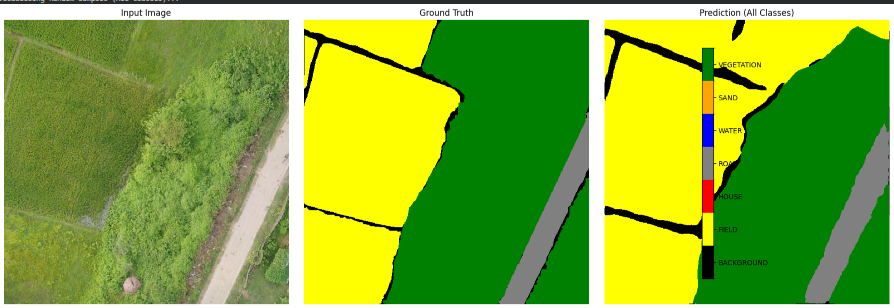

---

## Limitations of Classical and Semantic Segmentation On Our Dataset

**Goal:** Our main goal is to assess flood damage at the **individual parcel level** for compensation claims.

**Problem:** Two adjacent rice fields owned by different farmers. Semantic segmentation labels both as "rice field" but **cannot separate them into distinct parcels**.

**Missing Capabilities:**
- Count total affected parcels
- Calculate per-parcel damage area  
- Generate individualized compensation reports
- Validate land ownership boundaries


**Classical Techniques:** Detect visual discontinuity (shadows, texture). Agricultural boundaries encode **ownership/tenure**, not visual edges. A 30cm mud ridge has near-zero gradient.

**Semantic (UNet):** Learns *"what"* (rice, house, road) but not *"which instance"*. Achieves 95.37% Field IoU but cannot separate individual fields.

**Example—Houses:**  
- Classical: Over-segments (shadows → boundaries) or under-segments (merges adjacent buildings)  
- Semantic: Labels roofs as "house" but cannot count 3 distinct buildings

---

## What Panoptic Segmentation Solved

**Things vs. Stuff:**
- **Things** (countable): Rice fields, houses, ponds → unique instance IDs  
- **Stuff** (amorphous): Roads, rivers, soil → semantic labels only

**See Lab3** for failure progression: classical spurious edges → semantic merging → panoptic deployment accuracy.

---

*Good luck with your segmentation experiments!*

# LAB PART -3
## Instance and Panoptic Segmentation with Mask2Former
---

### Learning Objectives

By the end of this lab, you will:
1. Understand the difference between Instance and Panoptic segmentation
2. Use Mask2Former with HuggingFace Transformers for Panoptic tasks
3. Properly post-process model outputs using the official API
4. Evaluate models using PQ (Panoptic Quality)
5. Visualize and interpret segmentation results

### Prerequisites
- Basic PyTorch knowledge
- Understanding of CNNs and image classification
- Familiarity with object detection concepts

### References
1. Cheng et al., "Masked-attention Mask Transformer for Universal Image Segmentation" (CVPR 2022)
2. Kirillov et al., "Panoptic Segmentation" (CVPR 2019)

---

**Important:** This notebook requires a GPU. In Colab: `Runtime -> Change runtime type -> GPU`

# Part 0: Theoretical Background

## 0.1 Segmentation Task Types

There are three main image segmentation paradigms:

| Task | What it does | Output | Key Metric |
|------|-------------|--------|------------|
| **Semantic** | Labels every pixel with a class | Dense class map | mIoU |
| **Instance** | Detects and segments individual objects | Per-object masks + class | AP |
| **Panoptic** | Combines both: instances for "things", semantic for "stuff" | Complete scene parsing | PQ |

<div align="center">
<img src="https://images.prismic.io/encord/687a497d-e323-4772-8cd4-4bd67b9dd9a5_image7.png?auto=compress,format" width="800">
</div>

*Figure 1: Comparison of segmentation types. Notice how instance segmentation distinguishes individual objects.*

## 0.2 Instance Segmentation

**Goal:** Detect each object instance and produce a binary mask for it.

**Output for each detected instance:**
- Class label: $c_i \in \{1, ..., K\}$
- Confidence score: $s_i \in [0-1]$
- Binary mask: $m_i \in \{0, 1\}^{H \times W}$

**Evaluation Metric: Average Precision (AP)**

AP measures both detection and segmentation quality:

1. For each prediction, compute IoU with ground truth masks
2. A prediction is True Positive if IoU > threshold (typically 0.5)
3. Compute Precision-Recall curve across confidence thresholds
4. AP = Area under the PR curve

$$AP = \int_0^1 P(r) \, dr$$

Where
𝑃
(
𝑟
)
is the precision at recall
r. This integral calculates the area under the PR curve.

COCO-style mAP averages over IoU thresholds {0.50, 0.55, ..., 0.95}:
$$mAP = \frac{1}{10} \sum_{t} AP_t$$

## 0.3 Panoptic Segmentation

**Goal:** Provide complete scene understanding by segmenting everything.

**Key Concept: Things vs Stuff**

| Category | Description | Examples | Segmentation Type |
|----------|-------------|----------|-------------------|
| **Things** | Countable objects | Cars, people, animals | Instance (each gets unique ID) |
| **Stuff** | Amorphous regions | Sky, road, grass | Semantic (shared class ID) |

**Output:** A panoptic map where each pixel has:
- Semantic class
- Instance ID (unique for things, shared for stuff)

**Evaluation Metric: Panoptic Quality (PQ)**

$$PQ = \underbrace{\frac{\sum_{(p,g) \in TP} IoU(p,g)}{|TP|}}_{SQ} \times \underbrace{\frac{|TP|}{|TP| + \frac{1}{2}|FP| + \frac{1}{2}|FN|}}_{RQ}$$

Where:
- **SQ (Segmentation Quality):** Average IoU of matched segments
- **RQ (Recognition Quality):** F1-score of segment matching
- **TP:** Predictions matching GT with IoU > 0.5
- **FP:** Predictions without matching GT
- **FN:** GT segments without matching predictions

## 0.4 Mask2Former Architecture

Mask2Former is a **universal architecture** that handles all segmentation tasks with the same model structure.

<div align="center">
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/mask2former_architecture.png" width="800">
</div>

**Key Components:**

1. **Backbone:** Extracts multi-scale features (ResNet, Swin Transformer)
2. **Pixel Decoder:** Upsamples features to high resolution
3. **Transformer Decoder:** Uses learnable queries to predict masks

---

### **The Query Mechanism:**
- Model has N learnable "object queries" (typically 100).
- Each query predicts ONE potential object/segment.
- Outputs: class probabilities + mask embedding per query.
- **Final mask** = dot product of embedding with pixel features.

---

### **Key Innovation: Masked Cross-Attention**

Instead of attending to all pixels, each query only attends to its predicted mask region:

$$\text{MaskedAttn}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}} + M\right)V$$

Where:
- \( Q \): Query matrix (learnable queries)
- \( K \): Key matrix (representations of the image pixels)
- \( V \): Value matrix (pixel features)
- \( M \): A mask matrix with \( M_{ij} = -\infty \) for pixels outside the predicted mask region and \( M_{ij} = 0 \) for pixels inside the mask.

The **mask matrix** \( M \) ensures that each query only attends to pixels inside its predicted mask region. This reduces computational complexity while making the attention mechanism more focused.

---

### **Softmax Expression**

The **softmax** function is used to normalize the attention scores, converting them into probabilities:

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

Where $x_i$ represents the attention score for pixel $i$ (computed as $\frac{QK^T}{\sqrt{d}} + M$) and the denominator normalizes the scores so that they sum to 1. This ensures that each query attends more strongly to the pixels that are more relevant to the object it is predicting.

---

### **Example of How Masked Attention Works:**

Let's consider an example where we have an image with two objects: a **dog** and a **cat**.

#### **Step 1: Backbone and Feature Extraction**
- The model passes the image through the **backbone** (like ResNet or Swin Transformer) to extract multi-scale features.
- These features capture various levels of information, including object shapes, colors, and textures.

#### **Step 2: Pixel Decoder**
- The pixel decoder **upsamples** these features to a high resolution to ensure that the final segmentation mask is precise at the pixel level.

#### **Step 3: Query Mechanism**
- The transformer decoder uses **100 learnable queries**. Each query is responsible for predicting one object.
  
#### **Step 4: Applying Masked Cross-Attention**
- Suppose the first query is for predicting a **dog** and the second query is for predicting a **cat**.
- The **masked attention** mechanism ensures that the **dog query** only attends to pixels that are likely part of the dog, and the **cat query** focuses only on pixels that are part of the cat.
- For each query, the attention score is computed as:

$$\text{MaskedAttn}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}} + M\right)V$$

- The matrix \( M \) forces the attention to focus only on pixels inside the predicted mask region, effectively masking out irrelevant regions (e.g., background or parts of other objects).
- This improves computational efficiency and focuses the attention on the relevant regions.

#### **Step 5: Final Mask Prediction**
- After applying masked attention, each query produces a **mask embedding** (a vector representation of the object's mask).
- The final mask is computed by applying the **sigmoid function** to the mask embedding:

$$\text{MaskedAttn}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}} + M\right)V$$

Where $\sigma(x)$ is the **sigmoid** function:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

- The result is a probability value for each pixel indicating whether it belongs to the object (dog or cat).
- Typically, the output mask is thresholded at 0.5 to create a binary mask: pixels with probabilities greater than 0.5 are part of the object, and those below 0.5 are not.

---

### **Final Output:**
- Each query predicts a **class label** (dog or cat) and a **segmentation mask**.
- The model outputs **class probabilities** for each query and the final binary masks for all objects in the image.

---

### **Summary:**
Mask2Former uses **masked cross-attention** to focus attention on relevant regions of an image for each object, improving both computational efficiency and segmentation accuracy. The architecture uses **learnable queries** and applies the **sigmoid** function to generate final binary masks. The attention mechanism and softmax activation ensure that the model can focus on the most relevant parts of the image for each object it predicts.


## 0.5 Instance vs Panoptic in Mask2Former

The **same architecture** handles both tasks. The difference is in:

1. **Which classes are included:**
   - Instance: Only "things" (countable objects)
   - Panoptic: Both "things" and "stuff"

2. **Post-processing:**
   - Instance: Filter by confidence, allow overlapping masks
   - Panoptic: Resolve overlaps, assign every pixel to exactly one segment

---

# Part 1: Environment Setup

This section sets up all dependencies with proper error handling.

In [ ]:
#Import Libraries
import os
import sys
import json
import random
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from collections import defaultdict
from dataclasses import dataclass

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import (
    Mask2FormerForUniversalSegmentation,
    Mask2FormerImageProcessor,
)

from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

import albumentations as A
from tqdm.auto import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

In [ ]:
#Device Configuration and Reproducibility

def setup_environment(seed: int = 42):
    # Set all random seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

    # Determine device
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    else:
        device = torch.device('cpu')
        print("WARNING: No GPU detected. Training will be very slow.")

    return device

# Run setup
SEED = 42
DEVICE = setup_environment(SEED)
print(f"\nDevice: {DEVICE}")
print(f"Random seed: {SEED}")

In [ ]:
# All configurable values in ONE place for easy modification.

@dataclass
class Config:
    # Dataset paths - UPDATE THESE FOR YOUR SETUP
    data_root: str = "/content/FloodSight-2-2"
    train_dir: str = "train"
    val_dir: str = "valid"
    test_dir: str = "test"
    annotation_file: str = "_annotations.coco.json"

    # Image settings
    image_size: Tuple[int, int] = (512, 512)  # (height, width)
    image_format: str = "RGB"  # We use RGB consistently throughout

    # Model settings
    instance_model: str = "facebook/mask2former-swin-tiny-coco-instance"
    panoptic_model: str = "facebook/mask2former-swin-tiny-coco-panoptic"

    # Training settings
    batch_size: int = 2
    num_epochs: int = 5
    learning_rate: float = 1e-4
    backbone_lr_factor: float = 0.1  # Backbone uses lr * this factor
    weight_decay: float = 0.01
    gradient_accumulation: int = 4
    max_grad_norm: float = 0.1

    # Inference settings
    confidence_threshold: float = 0.5
    iou_threshold: float = 0.5  # For AP/PQ computation

    # Ignore index for loss computation
    ignore_index: int = 255

    # Random seed (already set above)
    seed: int = 42

CONFIG = Config()
print("Configuration loaded:")
print(f"  Image size: {CONFIG.image_size}")
print(f"  Batch size: {CONFIG.batch_size}")
print(f"  Epochs: {CONFIG.num_epochs}")

---

# Part 2: Dataset Setup and Validation

This section handles dataset loading with **proper validation and error handling**.

A production-safe dataset loader must:
1. Validate that files exist
2. Handle missing/corrupt annotations gracefully
3. Skip invalid samples without crashing
4. Log warnings for debugging

Download Data From Google Drive

In [ ]:
!gdown --folder --remaining-ok https://drive.google.com/drive/folders/1F-tZjJx-JuM7QQw6LWsKkSuo3IOfWTYj

In [ ]:
# !unzip /content/LAB_MATERIAL/drive-download-20260102T095851Z-1-001.zip -d /content/data

In [ ]:
# Corrected ID mapping
ID_MAPPING = {
    0: 0,                          # objects-p8wr -> Background (0)
    3: 0,                          # GROUND -> Background (0)
    1: 1,                          # BARREN_FIELD -> Field (1)
    4: 1,                          # GROWING_FIELD -> Field (1)
    7: 1,                          # MARSH_FIELD -> Field (1)
    9: 1,                          # NONCROP_FIELD -> Field (1)
    5: 2,                          # HOUSE -> House (2)
    10: 3,                         # ROAD -> Road (3)
    6: 4,                          # IRRIGATION_CHANNEL -> Water (4)
    14: 4,                         # WATER -> Water (4)
    11: 5,                         # SAND -> Sand (5)
    8: 6,                          # MARSH_VEGETATION -> Vegetation (6)
    12: 6,                         # TREES -> Vegetation (6)
    13: 6,                         # VEGETATION -> Vegetation (6)
    2: CONFIG.ignore_index,        # EDGECASE_IGNORE -> Ignore (255)
}

# Class metadata with distinct colors
CLASS_INFO = {
    0: {"name": "Background",  "is_thing": False, "color": [40, 40, 40]},       # Dark Gray
    1: {"name": "Field",       "is_thing": True, "color": [255, 255, 0]},      # Bright Yellow
    2: {"name": "House",       "is_thing": True,  "color": [255, 0, 0]},        # Red
    3: {"name": "Road",        "is_thing": False, "color": [128, 128, 128]},    # Gray
    4: {"name": "Water",       "is_thing": False, "color": [0, 128, 255]},      # Blue
    5: {"name": "Sand",        "is_thing": False, "color": [255, 165, 0]},      # Orange
    6: {"name": "Vegetation",  "is_thing": False,  "color": [0, 180, 0]},        # Green
}

NUM_CLASSES = len(CLASS_INFO)
CLASS_NAMES = {i: CLASS_INFO[i]["name"] for i in range(NUM_CLASSES)}
THING_IDS = set(i for i in range(NUM_CLASSES) if CLASS_INFO[i]["is_thing"])
STUFF_IDS = set(i for i in range(NUM_CLASSES) if not CLASS_INFO[i]["is_thing"])
CLASS_COLORS = np.array([CLASS_INFO[i]["color"] for i in range(NUM_CLASSES)], dtype=np.uint8)

# For panoptic segmentation
STUFF_CLASS_IDS = STUFF_IDS
THING_CLASS_IDS = THING_IDS
LABEL_IDS_TO_FUSE = STUFF_CLASS_IDS.copy()

print("=" * 60)
print("CLASS CONFIGURATION (CORRECTED)")
print("=" * 60)

print(f"\nNumber of classes: {NUM_CLASSES}")
print(f"\nThing classes (instances - House, Vegetation):")
for i in sorted(THING_IDS):
    print(f"  {i}: {CLASS_NAMES[i]:12s} -> RGB{tuple(CLASS_COLORS[i])}")

print(f"\nStuff classes (semantic - will be fused):")
for i in sorted(STUFF_IDS):
    print(f"  {i}: {CLASS_NAMES[i]:12s} -> RGB{tuple(CLASS_COLORS[i])}")


In [ ]:
# Dataset Validation Functions

def validate_dataset_path(config: Config) -> Dict[str, Path]:
    """
    Validate that all dataset paths exist.
    Returns dict of validated paths or raises informative error.
    """
    paths = {}
    errors = []

    root = Path(config.data_root)
    if not root.exists():
        errors.append(f"Data root not found: {root}")

    for split_name, split_dir in [("train", config.train_dir),
                                   ("val", config.val_dir),
                                   ("test", config.test_dir)]:
        split_path = root / split_dir
        ann_path = split_path / config.annotation_file

        if not split_path.exists():
            errors.append(f"{split_name} directory not found: {split_path}")
        elif not ann_path.exists():
            errors.append(f"{split_name} annotations not found: {ann_path}")
        else:
            paths[split_name] = split_path
            print(f"[OK] {split_name}: {split_path}")

    if errors:
        print("\n[ERRORS]")
        for e in errors:
            print(f"  - {e}")
        print("\nPlease update CONFIG.data_root and directory names.")
        return {}

    return paths


def validate_annotation(ann: Dict, coco: COCO, img_shape: Tuple[int, int]) -> bool:
    """
    Validate a single annotation.
    Returns True if valid, False if should be skipped.
    """
    # Check required fields
    required = ['id', 'image_id', 'category_id', 'segmentation']
    for field in required:
        if field not in ann:
            return False

    # Check category mapping
    cat_id = ann['category_id']
    if cat_id not in ID_MAPPING:
        return False

    mapped_id = ID_MAPPING[cat_id]
    if mapped_id == CONFIG.ignore_index:
        return False  # Skip ignored classes

    # Check for crowd annotations (we skip these)
    if ann.get('iscrowd', 0) == 1:
        return False

    # Check segmentation is not empty
    seg = ann['segmentation']
    if isinstance(seg, list) and len(seg) == 0:
        return False

    return True


# Validate paths
DATASET_PATHS = validate_dataset_path(CONFIG)

In [ ]:
#Dataset Class with Proper Error Handling

class SegmentationDataset(Dataset):
    """
    Dataset for instance/panoptic segmentation with COCO-format annotations.

    """

    def __init__(
        self,
        root_dir: Path,
        processor: Mask2FormerImageProcessor,
        transform: Optional[A.Compose] = None,
        id_mapping: Dict[int, int] = ID_MAPPING,
        ignore_index: int = CONFIG.ignore_index,
    ):
        self.root_dir = Path(root_dir)
        self.processor = processor
        self.transform = transform
        self.id_mapping = id_mapping
        self.ignore_index = ignore_index

        # Load COCO annotations
        ann_path = self.root_dir / CONFIG.annotation_file
        print(f"Loading annotations from {ann_path}...")
        self.coco = COCO(str(ann_path))

        # Filter valid images
        self.valid_samples = self._validate_samples()
        print(f"Valid samples: {len(self.valid_samples)}/{len(self.coco.imgs)}")

    def _validate_samples(self) -> List[int]:
        """Pre-validate all samples and return list of valid image IDs."""
        valid_ids = []
        skipped = {"no_file": 0, "no_valid_ann": 0, "load_error": 0}

        for img_id in self.coco.imgs:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = self.root_dir / img_info['file_name']

            # Check file exists
            if not img_path.exists():
                skipped["no_file"] += 1
                continue

            # Check has valid annotations
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)

            img_shape = (img_info['height'], img_info['width'])
            valid_anns = [a for a in anns if validate_annotation(a, self.coco, img_shape)]

            if len(valid_anns) == 0:
                skipped["no_valid_ann"] += 1
                continue

            valid_ids.append(img_id)

        if any(v > 0 for v in skipped.values()):
            print(f"  Skipped: {skipped}")

        return valid_ids

    def __len__(self) -> int:
        return len(self.valid_samples)

    def _load_image_rgb(self, path: Path) -> Optional[np.ndarray]:
        """Load image as RGB numpy array."""
        try:
            # Use PIL for consistent RGB loading
            img = Image.open(path).convert('RGB')
            return np.array(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            return None

    def _extract_masks(self, anns: List[Dict], img_shape: Tuple[int, int]) -> Tuple[List[np.ndarray], List[int]]:
        """Extract binary masks and class labels from annotations."""
        masks = []
        labels = []

        for ann in anns:
            if not validate_annotation(ann, self.coco, img_shape):
                continue

            # Get mapped class ID
            orig_cat = ann['category_id']
            mapped_cat = self.id_mapping.get(orig_cat, self.ignore_index)
            if mapped_cat == self.ignore_index:
                continue

            # Extract mask
            try:
                mask = self.coco.annToMask(ann)

                # Resize if needed
                if mask.shape[:2] != img_shape:
                    mask = cv2.resize(
                        mask.astype(np.uint8),
                        (img_shape[1], img_shape[0]),
                        interpolation=cv2.INTER_NEAREST
                    )

                masks.append(mask)
                labels.append(mapped_cat)

            except Exception as e:
                # Skip this annotation but continue with others
                continue

        return masks, labels

    def __getitem__(self, idx: int) -> Optional[Dict[str, Any]]:
        """
        Get a single sample.

        Returns None for invalid samples (handled by collate_fn).
        """
        img_id = self.valid_samples[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.root_dir / img_info['file_name']

        # Load image (RGB format)
        image = self._load_image_rgb(img_path)
        if image is None:
            return None

        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Extract masks
        img_shape = image.shape[:2]
        masks, labels = self._extract_masks(anns, img_shape)

        if len(masks) == 0:
            return None

        # Apply augmentations (Albumentations expects RGB)
        if self.transform:
            try:
                transformed = self.transform(image=image, masks=masks)
                image = transformed['image']
                masks = transformed['masks']
            except Exception as e:
                print(f"Augmentation error for image {img_id}: {e}")
                return None

        if len(masks) == 0:
            return None

        # Process with Mask2Former processor
        inputs = self.processor(images=image, return_tensors="pt")

        return {
            "pixel_values": inputs['pixel_values'].squeeze(0),
            "pixel_mask": inputs.get('pixel_mask', torch.ones(1, *CONFIG.image_size)).squeeze(0),
            "mask_labels": torch.tensor(np.stack(masks), dtype=torch.float32),
            "class_labels": torch.tensor(labels, dtype=torch.long),
            "image_id": img_id,
            "original_size": img_shape,
        }


def collate_fn(batch: List[Optional[Dict]]) -> Optional[Dict]:
    """
    Custom collate function that handles None samples.
    """
    # Filter out None samples
    batch = [b for b in batch if b is not None]

    if len(batch) == 0:
        return None

    return {
        "pixel_values": torch.stack([b['pixel_values'] for b in batch]),
        "pixel_mask": torch.stack([b['pixel_mask'] for b in batch]),
        "mask_labels": [b['mask_labels'] for b in batch],
        "class_labels": [b['class_labels'] for b in batch],
        "image_ids": [b['image_id'] for b in batch],
        "original_sizes": [b['original_size'] for b in batch],
    }


print("Dataset class defined.")

In [ ]:
# Data Augmentation

# Training augmentations
train_transform = A.Compose([
    A.Resize(height=CONFIG.image_size[0], width=CONFIG.image_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
])

# Validation/test - only resize
val_transform = A.Compose([
    A.Resize(height=CONFIG.image_size[0], width=CONFIG.image_size[1]),
])

print("Augmentation transforms configured.")
print(f"  Training: Resize + Flip + Rotate + BrightnessContrast")
print(f"  Validation: Resize only")

In [ ]:
# Create Datasets and Visualize

if DATASET_PATHS:
    # Create processor (we'll use instance model processor for now)
    processor = Mask2FormerImageProcessor.from_pretrained(
        CONFIG.instance_model,
        ignore_index=CONFIG.ignore_index,
        size={"height": CONFIG.image_size[0], "width": CONFIG.image_size[1]},
    )

    # Create datasets
    print("\nCreating datasets...")
    train_dataset = SegmentationDataset(
        DATASET_PATHS["train"], processor, train_transform
    )
    val_dataset = SegmentationDataset(
        DATASET_PATHS["val"], processor, val_transform
    )
    test_dataset = SegmentationDataset(
        DATASET_PATHS["test"], processor, val_transform
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG.batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )

    print(f"\nDataset sizes:")
    print(f"  Train: {len(train_dataset)}")
    print(f"  Val: {len(val_dataset)}")
    print(f"  Test: {len(test_dataset)}")
else:
    print("Dataset paths not configured. Please update CONFIG.data_root")

In [ ]:
# Visualize Sample (Updated with Class Labels)

def get_mask_centroid(mask: np.ndarray) -> tuple:
    """Get centroid of a binary mask for label placement."""
    coords = np.where(mask)
    if len(coords[0]) == 0:
        return None
    y_center = int(np.mean(coords[0]))
    x_center = int(np.mean(coords[1]))
    return (x_center, y_center)


def visualize_sample(
    image: np.ndarray,
    masks: np.ndarray,
    labels: np.ndarray,
    title: str = "Sample",
    alpha: float = 0.6,
    font_scale: float = 0.5,
    font_thickness: int = 2,
) -> None:
    """Visualize image with instance masks and class labels."""

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    H, W = image.shape[:2]

    # 1. Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[0].axis("off")

    # 2. Instance Masks Overlay with Labels
    overlay = image.copy().astype(np.float32)
    label_positions = []

    for inst_idx, (mask, label) in enumerate(zip(masks, labels)):
        if label == CONFIG.ignore_index:
            continue

        # Resize mask if needed
        if mask.shape != (H, W):
            mask = cv2.resize(
                mask.astype(np.uint8),
                (W, H),
                interpolation=cv2.INTER_NEAREST,
            )

        binary_mask = mask > 0.5

        # Get color with instance variation
        base_color = CLASS_COLORS[label].astype(np.float32)
        instance_shift = (inst_idx * 30) % 60 - 30
        color = np.clip(base_color + instance_shift, 0, 255) / 255.0

        # Apply overlay
        mask_3d = np.stack([binary_mask] * 3, axis=-1)
        overlay = np.where(
            mask_3d,
            overlay * (1 - alpha) + color * 255 * alpha,
            overlay,
        )

        # Draw contours
        contours, _ = cv2.findContours(
            binary_mask.astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE,
        )
        cv2.drawContours(overlay, contours, -1, (255, 255, 255), 2)

        # Get centroid for label
        centroid = get_mask_centroid(binary_mask)
        if centroid is not None:
            label_positions.append((centroid, CLASS_NAMES[label], label))

    # Draw class labels
    overlay = overlay.astype(np.uint8)
    for (x, y), class_name, class_id in label_positions:
        (text_w, text_h), baseline = cv2.getTextSize(
            class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
        )

        # Background rectangle
        cv2.rectangle(
            overlay,
            (x - text_w // 2 - 2, y - text_h // 2 - 2),
            (x + text_w // 2 + 2, y + text_h // 2 + 2),
            (0, 0, 0),
            -1
        )

        # Text
        cv2.putText(
            overlay,
            class_name,
            (x - text_w // 2, y + text_h // 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness,
            cv2.LINE_AA
        )

    axes[1].imshow(overlay)
    axes[1].set_title(f"Instance Masks ({len(masks)} instances)", fontsize=12, fontweight='bold')
    axes[1].axis("off")

    # 3. Semantic Segmentation Map
    semantic_map = np.zeros((H, W), dtype=np.uint8)

    for mask, label in zip(masks, labels):
        if label == CONFIG.ignore_index:
            continue

        if mask.shape != (H, W):
            mask = cv2.resize(
                mask.astype(np.uint8),
                (W, H),
                interpolation=cv2.INTER_NEAREST,
            )

        binary_mask = mask > 0.5
        semantic_map[binary_mask] = label

    # Color the semantic map
    semantic_colored = CLASS_COLORS[semantic_map]

    axes[2].imshow(semantic_colored)
    axes[2].set_title("Semantic Map", fontsize=12, fontweight='bold')
    axes[2].axis("off")

    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


print("visualize_sample function updated with class labels!")

In [ ]:
# Class Distribution Visualization (Updated)

def visualize_class_distribution(
    dataset: SegmentationDataset,
    max_samples: int = 100,
) -> dict:
    """Analyze and visualize class distribution in dataset."""

    class_counts = {i: 0 for i in range(NUM_CLASSES)}
    class_pixel_counts = {i: 0 for i in range(NUM_CLASSES)}

    n_samples = min(max_samples, len(dataset))

    for idx in tqdm(range(n_samples), desc="Analyzing distribution"):
        sample = dataset[idx]
        if sample is None:
            continue

        labels = sample['class_labels'].numpy()
        masks = sample['mask_labels'].numpy()

        for mask, label in zip(masks, labels):
            if label == CONFIG.ignore_index:
                continue
            if label < NUM_CLASSES:
                class_counts[label] += 1
                class_pixel_counts[label] += np.sum(mask > 0.5)

    # Plot instance counts
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Instance counts
    names = [CLASS_NAMES[i] for i in range(NUM_CLASSES)]
    counts = [class_counts[i] for i in range(NUM_CLASSES)]
    colors = [CLASS_COLORS[i] / 255.0 for i in range(NUM_CLASSES)]

    bars1 = axes[0].bar(names, counts, color=colors, edgecolor='black')
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Instance Count")
    axes[0].set_title(f"Instance Distribution (n={n_samples} images)", fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for bar, count in zip(bars1, counts):
        if count > 0:
            axes[0].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.5,
                str(count),
                ha='center',
                va='bottom',
                fontsize=9
            )

    # Pixel counts
    pixel_counts = [class_pixel_counts[i] / 1e6 for i in range(NUM_CLASSES)]  # In millions

    bars2 = axes[1].bar(names, pixel_counts, color=colors, edgecolor='black')
    axes[1].set_xlabel("Class")
    axes[1].set_ylabel("Pixel Count (Millions)")
    axes[1].set_title(f"Pixel Distribution (n={n_samples} images)", fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for bar, count in zip(bars2, pixel_counts):
        if count > 0:
            axes[1].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.01,
                f"{count:.2f}M",
                ha='center',
                va='bottom',
                fontsize=9
            )

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nClass Distribution Summary:")
    print("-" * 50)
    print(f"{'Class':<15} {'Instances':<12} {'Pixels (M)':<12}")
    print("-" * 50)
    for i in range(NUM_CLASSES):
        print(f"{CLASS_NAMES[i]:<15} {class_counts[i]:<12} {class_pixel_counts[i]/1e6:<12.2f}")

    return {
        'instance_counts': class_counts,
        'pixel_counts': class_pixel_counts,
    }


print("visualize_class_distribution function updated!")

In [ ]:
# Visualize Dataset Samples (Random Selection)

if DATASET_PATHS:
    print("=" * 60)
    print("DATASET VISUALIZATION (Random Samples)")
    print("=" * 60)

    # Visualize random samples
    vis_dataset = SegmentationDataset(DATASET_PATHS["train"], processor, None)

    # Random selection
    num_samples = 3
    random_seed = None  # Set to integer for reproducibility, None for fully random

    if random_seed is not None:
        np.random.seed(random_seed)

    # Get random indices
    all_indices = list(range(len(vis_dataset)))
    np.random.shuffle(all_indices)

    shown = 0
    idx_pos = 0

    while shown < num_samples and idx_pos < len(all_indices):
        idx = all_indices[idx_pos]
        idx_pos += 1

        sample = vis_dataset[idx]
        if sample is None:
            continue

        # Load original image for visualization
        img_id = sample['image_id']
        img_info = vis_dataset.coco.loadImgs(img_id)[0]
        img_path = vis_dataset.root_dir / img_info['file_name']
        image = np.array(Image.open(img_path).convert('RGB'))

        masks = sample['mask_labels'].numpy()
        labels = sample['class_labels'].numpy()

        visualize_sample(image, masks, labels, f"Training Sample (idx: {idx})")
        shown += 1

    # Analyze distribution
    print("CLASS DISTRIBUTION ANALYSIS")
    print("=" * 60)
    distribution = visualize_class_distribution(vis_dataset)

### Checkpoint 1: Dataset Verification

Before proceeding, verify that:
1. All three dataset splits loaded successfully
2. Sample visualizations show correct masks
3. Class distribution is reasonable

If you see errors, check your dataset paths and annotation format.

---

# Part 4: Panoptic Segmentation

Panoptic segmentation combines instance and semantic segmentation to provide complete scene understanding.

**Key difference from instance:**
- Includes "stuff" classes (amorphous regions like road, water, vegetation)
- Output is non-overlapping (every pixel assigned to exactly one segment)
- Uses Panoptic Quality (PQ) metric instead of AP

In [ ]:
#Load Panoptic Model

print("Loading Panoptic Segmentation Model...")
print(f"Model: {CONFIG.panoptic_model}")

panoptic_processor = Mask2FormerImageProcessor.from_pretrained(
    CONFIG.panoptic_model,
    ignore_index=CONFIG.ignore_index,
    size={"height": CONFIG.image_size[0], "width": CONFIG.image_size[1]},
)

panoptic_model = Mask2FormerForUniversalSegmentation.from_pretrained(
    CONFIG.panoptic_model,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True,
)
panoptic_model = panoptic_model.to(DEVICE)

print(f"Model loaded successfully.")

In [ ]:
# CELL 4.2: Panoptic Post-Processing (FIXED)

def run_panoptic_inference(
    model: Mask2FormerForUniversalSegmentation,
    processor: Mask2FormerImageProcessor,
    image: np.ndarray,
    threshold: float = CONFIG.confidence_threshold,
    device: torch.device = DEVICE,
    label_ids_to_fuse: set = None,  # Will use LABEL_IDS_TO_FUSE by default
) -> Dict:
    """
    Run panoptic segmentation inference with PROPER post-processing.

    Stuff classes (Road, Field, Water, Sand, Background) are fused.
    Thing classes (House, Vegetation) maintain separate instances.
    """
    if label_ids_to_fuse is None:
        label_ids_to_fuse = LABEL_IDS_TO_FUSE

    model.eval()
    original_size = image.shape[:2]

    # Preprocess
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # PANOPTIC POST-PROCESSING with label_ids_to_fuse
    results = processor.post_process_panoptic_segmentation(
        outputs,
        target_sizes=[original_size],
        threshold=threshold,
        label_ids_to_fuse=label_ids_to_fuse,  # THIS REMOVES THE WARNING
    )[0]

    segmentation = results['segmentation'].cpu().numpy()
    segments_info = results['segments_info']

    # Create semantic mask
    semantic = np.zeros(original_size, dtype=np.uint8)
    for seg_info in segments_info:
        seg_id = seg_info['id']
        class_id = seg_info['label_id']
        mask = (segmentation == seg_id)
        semantic[mask] = class_id

    # Extract masks with proper is_thing flag
    masks = []
    labels = []
    scores = []
    is_thing = []

    for seg_info in segments_info:
        seg_id = seg_info['id']
        class_id = seg_info['label_id']
        mask = (segmentation == seg_id).astype(np.uint8)
        masks.append(mask)
        labels.append(class_id)
        scores.append(seg_info.get('score', 1.0))
        # Thing = NOT in stuff classes
        is_thing.append(class_id in THING_CLASS_IDS)

    return {
        'segmentation': segmentation,
        'segments_info': segments_info,
        'semantic': semantic,
        'masks': masks,
        'labels': labels,
        'scores': scores,
        'is_thing': is_thing,
    }


print("Panoptic inference function updated with label_ids_to_fuse.")
print("Warning messages will no longer appear!")

In [ ]:
# PQ Computation with Thing/Stuff Breakdown

def compute_pq_detailed(
    pred_masks: List[np.ndarray],
    pred_labels: List[int],
    gt_masks: List[np.ndarray],
    gt_labels: List[int],
    iou_threshold: float = 0.5,
    stuff_ids: set = STUFF_CLASS_IDS,
    thing_ids: set = THING_CLASS_IDS,
) -> Dict:
    """
    Compute Panoptic Quality with Thing/Stuff breakdown.

    Returns PQ, SQ, RQ for:
    - All classes combined
    - Thing classes only (House, Vegetation)
    - Stuff classes only (Road, Field, Water, Sand, Background)
    """
    # Separate into thing and stuff
    pred_thing = [(m, l) for m, l in zip(pred_masks, pred_labels) if l in thing_ids]
    pred_stuff = [(m, l) for m, l in zip(pred_masks, pred_labels) if l in stuff_ids]
    gt_thing = [(m, l) for m, l in zip(gt_masks, gt_labels) if l in thing_ids]
    gt_stuff = [(m, l) for m, l in zip(gt_masks, gt_labels) if l in stuff_ids]

    def _compute_pq(preds, gts):
        if not preds and not gts:
            return {'PQ': 1.0, 'SQ': 1.0, 'RQ': 1.0, 'TP': 0, 'FP': 0, 'FN': 0}

        tp = 0
        iou_sum = 0.0
        matched_gt = set()

        for p_idx, (pred_mask, pred_label) in enumerate(preds):
            best_iou = 0
            best_gt = -1

            for g_idx, (gt_mask, gt_label) in enumerate(gts):
                if g_idx in matched_gt:
                    continue
                if pred_label != gt_label:
                    continue

                iou = compute_iou(pred_mask, gt_mask)
                if iou > best_iou:
                    best_iou = iou
                    best_gt = g_idx

            if best_iou > iou_threshold and best_gt >= 0:
                tp += 1
                iou_sum += best_iou
                matched_gt.add(best_gt)

        fp = len(preds) - tp
        fn = len(gts) - len(matched_gt)

        sq = iou_sum / tp if tp > 0 else 0.0
        rq = tp / (tp + 0.5 * fp + 0.5 * fn) if (tp + fp + fn) > 0 else 0.0
        pq = sq * rq

        return {'PQ': pq, 'SQ': sq, 'RQ': rq, 'TP': tp, 'FP': fp, 'FN': fn}

    # Compute for all, thing, stuff
    all_result = _compute_pq(list(zip(pred_masks, pred_labels)),
                             list(zip(gt_masks, gt_labels)))
    thing_result = _compute_pq(pred_thing, gt_thing)
    stuff_result = _compute_pq(pred_stuff, gt_stuff)

    return {
        'PQ': all_result['PQ'],
        'SQ': all_result['SQ'],
        'RQ': all_result['RQ'],
        'PQ_thing': thing_result['PQ'],
        'SQ_thing': thing_result['SQ'],
        'RQ_thing': thing_result['RQ'],
        'PQ_stuff': stuff_result['PQ'],
        'SQ_stuff': stuff_result['SQ'],
        'RQ_stuff': stuff_result['RQ'],
    }


@torch.no_grad()
def evaluate_panoptic_pq(
    model: Mask2FormerForUniversalSegmentation,
    processor: Mask2FormerImageProcessor,
    dataset: SegmentationDataset,
    device: torch.device,
    max_samples: int = 50,
) -> Dict:
    """Evaluate model using Panoptic Quality with Thing/Stuff breakdown."""
    model.eval()

    metrics = {
        'PQ': [], 'SQ': [], 'RQ': [],
        'PQ_thing': [], 'SQ_thing': [], 'RQ_thing': [],
        'PQ_stuff': [], 'SQ_stuff': [], 'RQ_stuff': [],
    }

    n_samples = min(max_samples, len(dataset))

    for idx in tqdm(range(n_samples), desc="Evaluating PQ"):
        sample = dataset[idx]
        if sample is None:
            continue

        img_id = sample['image_id']
        img_info = dataset.coco.loadImgs(img_id)[0]
        img_path = dataset.root_dir / img_info['file_name']
        image = np.array(Image.open(img_path).convert('RGB'))

        # Inference (no more warnings!)
        result = run_panoptic_inference(model, processor, image, device=device)

        # GT
        gt_masks = []
        gt_labels = []
        for m, l in zip(sample['mask_labels'].numpy(), sample['class_labels'].numpy()):
            if l != CONFIG.ignore_index:
                if m.shape != image.shape[:2]:
                    m = cv2.resize(m.astype(np.uint8),
                                  (image.shape[1], image.shape[0]),
                                  interpolation=cv2.INTER_NEAREST)
                gt_masks.append(m)
                gt_labels.append(int(l))

        # Compute detailed PQ
        pq_result = compute_pq_detailed(
            result['masks'], result['labels'],
            gt_masks, gt_labels,
            iou_threshold=CONFIG.iou_threshold
        )

        for key in metrics:
            metrics[key].append(pq_result[key])

    return {key: np.mean(vals) if vals else 0.0 for key, vals in metrics.items()}


print("PQ evaluation updated with Thing/Stuff breakdown.")
print("\nYour classes:")
print("  THING (House, Field): Separate instances")
print("  STUFF (Background, Vegetation, Road, Water, Sand): Fused regions")

In [ ]:
#Panoptic Training Setup


# Create panoptic datasets
if DATASET_PATHS:
    pan_train = SegmentationDataset(DATASET_PATHS["train"], panoptic_processor, train_transform)
    pan_val = SegmentationDataset(DATASET_PATHS["val"], panoptic_processor, val_transform)
    pan_test = SegmentationDataset(DATASET_PATHS["test"], panoptic_processor, val_transform)

    pan_train_loader = DataLoader(
        pan_train, batch_size=CONFIG.batch_size, shuffle=True,
        collate_fn=collate_fn, num_workers=2, pin_memory=True
    )
    pan_val_loader = DataLoader(
        pan_val, batch_size=CONFIG.batch_size, shuffle=False,
        collate_fn=collate_fn, num_workers=2, pin_memory=True
    )

# Optimizer for panoptic model
pan_backbone = [p for n, p in panoptic_model.named_parameters()
                if 'backbone' in n or 'pixel_level' in n]
pan_head = [p for n, p in panoptic_model.named_parameters()
            if 'backbone' not in n and 'pixel_level' not in n]

pan_optimizer = torch.optim.AdamW([
    {'params': pan_backbone, 'lr': CONFIG.learning_rate * CONFIG.backbone_lr_factor},
    {'params': pan_head, 'lr': CONFIG.learning_rate}
], weight_decay=CONFIG.weight_decay)

pan_total_steps = CONFIG.num_epochs * len(pan_train_loader)
pan_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    pan_optimizer, T_max=pan_total_steps, eta_min=1e-6
)

print("Panoptic training setup complete.")

In [ ]:
def compute_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """Compute Intersection over Union between two masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0


In [ ]:
# CELL 3.7: Training Functions

def train_one_epoch(
    model: Mask2FormerForUniversalSegmentation,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
    grad_accum: int = CONFIG.gradient_accumulation,
) -> float:
    """Train for one epoch. Returns average loss."""
    model.train()
    total_loss = 0
    n_batches = 0

    optimizer.zero_grad()
    progress = tqdm(loader, desc="Training")

    for batch_idx, batch in enumerate(progress):
        if batch is None:
            continue

        # Move to device
        pixel_values = batch['pixel_values'].to(device)
        mask_labels = [m.to(device) for m in batch['mask_labels']]
        class_labels = [c.to(device) for c in batch['class_labels']]

        # Forward
        outputs = model(
            pixel_values=pixel_values,
            mask_labels=mask_labels,
            class_labels=class_labels,
        )

        loss = outputs.loss / grad_accum
        loss.backward()

        # Update weights
        if (batch_idx + 1) % grad_accum == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG.max_grad_norm)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += outputs.loss.item()
        n_batches += 1

        progress.set_postfix({
            'loss': f'{total_loss/n_batches:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })

    return total_loss / n_batches if n_batches > 0 else float('inf')

print("Training functions defined.")

In [ ]:
#Panoptic Training Loop (Updated Output)


if DATASET_PATHS:

    best_pq = 0.0
    best_pan_state = None

    pan_history = {
        'train_loss': [],
        'val_pq': [], 'val_sq': [], 'val_rq': [],
        'val_pq_thing': [], 'val_pq_stuff': [],
    }

    for epoch in range(CONFIG.num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{CONFIG.num_epochs} [Panoptic]")
        print(f"{'='*50}")

        # Train
        train_loss = train_one_epoch(
            panoptic_model, pan_train_loader, pan_optimizer, pan_scheduler, DEVICE
        )
        pan_history['train_loss'].append(train_loss)

        # Evaluate
        val_metrics = evaluate_panoptic_pq(panoptic_model, panoptic_processor, pan_val, DEVICE)

        pan_history['val_pq'].append(val_metrics['PQ'])
        pan_history['val_sq'].append(val_metrics['SQ'])
        pan_history['val_rq'].append(val_metrics['RQ'])
        pan_history['val_pq_thing'].append(val_metrics['PQ_thing'])
        pan_history['val_pq_stuff'].append(val_metrics['PQ_stuff'])

        print(f"\nResults:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val PQ: {val_metrics['PQ']:.4f} (SQ: {val_metrics['SQ']:.4f}, RQ: {val_metrics['RQ']:.4f})")
        print(f"  Val PQ_thing: {val_metrics['PQ_thing']:.4f} (House, Vegetation)")
        print(f"  Val PQ_stuff: {val_metrics['PQ_stuff']:.4f} (Road, Field, Water, Sand, BG)")

        if val_metrics['PQ'] > best_pq:
            best_pq = val_metrics['PQ']
            best_pan_state = {k: v.cpu().clone() for k, v in panoptic_model.state_dict().items()}
            print(f"  [BEST] PQ improved to {best_pq:.4f}")

    if best_pan_state is not None:
        panoptic_model.load_state_dict(best_pan_state)
        panoptic_model = panoptic_model.to(DEVICE)

In [ ]:
#Plot Panoptic Training Curves

if DATASET_PATHS and len(pan_history['train_loss']) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    epochs = range(1, len(pan_history['train_loss']) + 1)

    axes[0].plot(epochs, pan_history['train_loss'], 'b-o', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, pan_history['val_pq'], 'g-o', linewidth=2, label='PQ')
    best_epoch = np.argmax(pan_history['val_pq']) + 1
    axes[1].axvline(x=best_epoch, color='r', linestyle='--',
                    label=f'Best: Epoch {best_epoch}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('PQ')
    axes[1].set_title('Validation Panoptic Quality')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(epochs, pan_history['val_sq'], 'c-o', linewidth=2, label='SQ')
    axes[2].plot(epochs, pan_history['val_rq'], 'm-s', linewidth=2, label='RQ')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Quality')
    axes[2].set_title('SQ and RQ Components')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.suptitle('Panoptic Segmentation Training', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('panoptic_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
#Visualize Panoptic Predictions (Random, Distinct Colors, Class Labels)

def get_mask_centroid(mask: np.ndarray) -> tuple:
    """Get centroid of a binary mask for label placement."""
    coords = np.where(mask)
    if len(coords[0]) == 0:
        return None
    y_center = int(np.mean(coords[0]))
    x_center = int(np.mean(coords[1]))
    return (x_center, y_center)


def visualize_panoptic_predictions(
    model: Mask2FormerForUniversalSegmentation,
    processor: Mask2FormerImageProcessor,
    dataset: SegmentationDataset,
    device: torch.device,
    num_samples: int = 4,
    alpha: float = 0.6,
    random_seed: int = None,
    font_scale: float = 0.5,
    font_thickness: int = 2,
) -> None:
    """Visualize Input, GT Panoptic Masks, and Predicted Panoptic Masks with class labels."""

    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    # RANDOM SELECTION
    if random_seed is not None:
        np.random.seed(random_seed)

    all_indices = list(range(len(dataset)))
    np.random.shuffle(all_indices)

    shown = 0
    idx_pos = 0

    while shown < num_samples and idx_pos < len(all_indices):
        idx = all_indices[idx_pos]
        idx_pos += 1

        sample = dataset[idx]
        if sample is None:
            continue


        # Load image

        img_id = sample["image_id"]
        img_info = dataset.coco.loadImgs(int(img_id))[0]
        img_path = dataset.root_dir / img_info["file_name"]
        image = np.array(Image.open(img_path).convert("RGB"))
        H, W = image.shape[:2]


        # Inference

        result = run_panoptic_inference(model, processor, image, device=device)


        # GT PANOPTIC OVERLAY with labels

        gt_overlay = image.copy().astype(np.float32)

        gt_masks = sample["mask_labels"].numpy()
        gt_labels = sample["class_labels"].numpy()

        gt_label_positions = []

        for inst_idx, (m, l) in enumerate(zip(gt_masks, gt_labels)):
            if l == CONFIG.ignore_index:
                continue

            if m.shape != (H, W):
                m = cv2.resize(
                    m.astype(np.uint8),
                    (W, H),
                    interpolation=cv2.INTER_NEAREST,
                )

            mask = m > 0.5
            base_color = CLASS_COLORS[l].astype(np.float32)
            instance_shift = (inst_idx * 30) % 60 - 30
            color = np.clip(base_color + instance_shift, 0, 255) / 255.0

            mask_3d = np.stack([mask] * 3, axis=-1)
            gt_overlay = np.where(
                mask_3d,
                gt_overlay * (1 - alpha) + color * 255 * alpha,
                gt_overlay,
            )

            # Draw contours
            contours, _ = cv2.findContours(
                mask.astype(np.uint8),
                cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE,
            )
            cv2.drawContours(gt_overlay, contours, -1, (255, 255, 255), 2)

            # Get centroid for label placement
            centroid = get_mask_centroid(mask)
            if centroid is not None:
                # Add thing/stuff indicator
                is_thing = l in THING_CLASS_IDS
                label_text = f"{CLASS_NAMES[l]}"
                gt_label_positions.append((centroid, label_text, l))

        # Draw class labels on GT overlay
        gt_overlay = gt_overlay.astype(np.uint8)
        for (x, y), class_name, class_id in gt_label_positions:
            (text_w, text_h), baseline = cv2.getTextSize(
                class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
            )

            # Draw background rectangle
            cv2.rectangle(
                gt_overlay,
                (x - text_w // 2 - 2, y - text_h // 2 - 2),
                (x + text_w // 2 + 2, y + text_h // 2 + 2),
                (0, 0, 0),
                -1
            )

            # Draw text
            cv2.putText(
                gt_overlay,
                class_name,
                (x - text_w // 2, y + text_h // 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),
                font_thickness,
                cv2.LINE_AA
            )


        # PREDICTED PANOPTIC OVERLAY with labels

        pred_overlay = image.copy().astype(np.float32)
        pred_label_positions = []

        for inst_idx, (mask, label) in enumerate(zip(result["masks"], result["labels"])):
            mask = mask.astype(bool)

            # Skip if label out of range
            if label >= len(CLASS_COLORS):
                continue

            base_color = CLASS_COLORS[label].astype(np.float32)
            instance_shift = (inst_idx * 30) % 60 - 30
            color = np.clip(base_color + instance_shift, 0, 255) / 255.0

            mask_3d = np.stack([mask] * 3, axis=-1)
            pred_overlay = np.where(
                mask_3d,
                pred_overlay * (1 - alpha) + color * 255 * alpha,
                pred_overlay,
            )

            # Draw contours
            contours, _ = cv2.findContours(
                mask.astype(np.uint8),
                cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE,
            )
            cv2.drawContours(pred_overlay, contours, -1, (255, 255, 255), 2)

            # Get centroid for label placement
            centroid = get_mask_centroid(mask)
            if centroid is not None:
                # Include confidence score and thing/stuff indicator
                is_thing = result["is_thing"][inst_idx] if "is_thing" in result else (label in THING_CLASS_IDS)
                type_indicator = "[T]" if is_thing else "[S]"

                if "scores" in result and inst_idx < len(result["scores"]):
                    score = result["scores"][inst_idx]
                    label_text = f"{CLASS_NAMES[label]} {score:.2f}"
                else:
                    label_text = f"{CLASS_NAMES[label]}"

                pred_label_positions.append((centroid, label_text, label))

        # Draw class labels on pred overlay
        pred_overlay = pred_overlay.astype(np.uint8)
        for (x, y), class_name, class_id in pred_label_positions:
            (text_w, text_h), baseline = cv2.getTextSize(
                class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
            )

            # Background rectangle
            cv2.rectangle(
                pred_overlay,
                (x - text_w // 2 - 2, y - text_h // 2 - 2),
                (x + text_w // 2 + 2, y + text_h // 2 + 2),
                (0, 0, 0),
                -1
            )

            # Text
            cv2.putText(
                pred_overlay,
                class_name,
                (x - text_w // 2, y + text_h // 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),
                font_thickness,
                cv2.LINE_AA
            )


        # Count segments by type

        num_thing = sum(1 for t in result.get("is_thing", []) if t)
        num_stuff = len(result["masks"]) - num_thing


        # Plot

        axes[shown, 0].imshow(image)
        axes[shown, 0].set_title(f"Input Image (idx: {idx})", fontsize=12, fontweight='bold')
        axes[shown, 0].axis("off")

        axes[shown, 1].imshow(gt_overlay)
        axes[shown, 1].set_title("GT Panoptic Masks", fontsize=12, fontweight='bold')
        axes[shown, 1].axis("off")

        axes[shown, 2].imshow(pred_overlay)
        axes[shown, 2].set_title(
            f"Predicted ({len(result['masks'])} segs: {num_thing}T/{num_stuff}S)",
            fontsize=12, fontweight='bold'
        )
        axes[shown, 2].axis("off")

        shown += 1

    plt.suptitle(
        "Mask2Former Panoptic Segmentation",
        fontsize=16,
        fontweight="bold",
        y=1.02
    )

    plt.tight_layout()
    plt.savefig("panoptic_predictions.png", dpi=150, bbox_inches="tight")
    plt.show()
# Run Visualizati
if DATASET_PATHS:
    print("PANOPTIC SEGMENTATION PREDICTIONS (Random + Class Labels)")

    visualize_panoptic_predictions(
        panoptic_model,
        panoptic_processor,
        pan_test,
        DEVICE,
        num_samples=4,
        random_seed=None,  # Fully random
        font_scale=0.5,    # Adjust text size
        font_thickness=2,  # Adjust text thickness
    )

In [ ]:
# Comprehensive Evaluation Metrics for Panoptic Segmentation

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import torch
from typing import Dict, List, Tuple
import cv2


# Metric Computation Functions

def compute_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """Compute Intersection over Union between two binary masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return intersection / union


def compute_dice(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """Compute Dice coefficient between two binary masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    total = mask1.sum() + mask2.sum()
    if total == 0:
        return 0.0
    return (2 * intersection) / total


def compute_precision_recall_f1(tp: int, fp: int, fn: int) -> Tuple[float, float, float]:
    """Compute precision, recall, and F1 score."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1


In [ ]:
# Main Panoptic Evaluation Function

@torch.no_grad()
def evaluate_panoptic_comprehensive(
    model: torch.nn.Module,
    processor,
    dataset,
    device: torch.device,
    iou_threshold: float = 0.5,
    max_samples: int = None,
) -> Dict:
    """
    Comprehensive panoptic evaluation with per-class metrics.

    Computes:
    - PQ (Panoptic Quality) = SQ * RQ
    - SQ (Segmentation Quality) = average IoU of matched segments
    - RQ (Recognition Quality) = TP / (TP + 0.5*FP + 0.5*FN)
    - IoU, Dice, Precision, Recall, F1 per class
    - Separate metrics for Thing and Stuff classes
    - Confusion matrix

    Returns:
        Dict with per_class_metrics, overall_metrics, thing_metrics, stuff_metrics, confusion_matrix
    """
    model.eval()

    num_classes = NUM_CLASSES
    n_samples = len(dataset) if max_samples is None else min(max_samples, len(dataset))

    # Per-class accumulators
    class_tp = defaultdict(int)
    class_fp = defaultdict(int)
    class_fn = defaultdict(int)
    class_iou_sum = defaultdict(float)
    class_dice_sum = defaultdict(float)
    class_match_count = defaultdict(int)

    # For PQ calculation per class
    class_pq_sum = defaultdict(float)
    class_sq_sum = defaultdict(float)
    class_rq_sum = defaultdict(float)
    class_pq_count = defaultdict(int)

    # Confusion matrix: rows = GT, cols = Pred
    confusion_matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int64)

    # Pixel-level confusion matrix for semantic evaluation
    pixel_confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    print(f"Evaluating {n_samples} samples...")

    for idx in tqdm(range(n_samples), desc="Evaluating Panoptic"):
        sample = dataset[idx]
        if sample is None:
            continue

        # Load image
        img_id = sample["image_id"]
        img_info = dataset.coco.loadImgs(int(img_id))[0]
        img_path = dataset.root_dir / img_info["file_name"]
        image = np.array(Image.open(img_path).convert("RGB"))
        H, W = image.shape[:2]

        # Run panoptic inference
        result = run_panoptic_inference(model, processor, image, device=device)

        # Get GT
        gt_masks = sample["mask_labels"].numpy()
        gt_labels = sample["class_labels"].numpy()

        # Resize and filter GT masks
        gt_masks_resized = []
        gt_labels_valid = []
        for m, l in zip(gt_masks, gt_labels):
            if l == CONFIG.ignore_index:
                continue
            if m.shape != (H, W):
                m = cv2.resize(m.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
            gt_masks_resized.append(m > 0.5)
            gt_labels_valid.append(int(l))

        # Get predictions
        pred_masks = [m.astype(bool) for m in result["masks"]]
        pred_labels = [int(l) for l in result["labels"]]
        pred_scores = result.get("scores", [1.0] * len(pred_masks))
        pred_is_thing = result.get("is_thing", [l in THING_CLASS_IDS for l in pred_labels])


        # Match predictions to GT (for each class separately)

        matched_gt = set()
        matched_pred = set()

        # Per-image PQ components
        image_class_tp = defaultdict(int)
        image_class_fp = defaultdict(int)
        image_class_fn = defaultdict(int)
        image_class_iou_sum = defaultdict(float)

        # Sort predictions by score
        sorted_pred_indices = np.argsort(pred_scores)[::-1]

        for p_idx in sorted_pred_indices:
            if p_idx >= len(pred_masks):
                continue

            pred_mask = pred_masks[p_idx]
            pred_label = pred_labels[p_idx]
            pred_score = pred_scores[p_idx]

            # Skip invalid labels
            if pred_label >= num_classes:
                continue

            best_iou = 0
            best_gt_idx = -1

            for g_idx, (gt_mask, gt_label) in enumerate(zip(gt_masks_resized, gt_labels_valid)):
                if g_idx in matched_gt:
                    continue
                if pred_label != gt_label:
                    continue

                iou = compute_iou(pred_mask, gt_mask)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = g_idx

            if best_iou >= iou_threshold and best_gt_idx >= 0:
                # True Positive
                class_tp[pred_label] += 1
                image_class_tp[pred_label] += 1
                matched_gt.add(best_gt_idx)
                matched_pred.add(p_idx)

                # Compute metrics
                gt_mask = gt_masks_resized[best_gt_idx]
                class_iou_sum[pred_label] += best_iou
                image_class_iou_sum[pred_label] += best_iou
                class_dice_sum[pred_label] += compute_dice(pred_mask, gt_mask)
                class_match_count[pred_label] += 1

                # Confusion matrix: correct
                confusion_matrix[pred_label, pred_label] += 1
            else:
                # False Positive
                class_fp[pred_label] += 1
                image_class_fp[pred_label] += 1

                # Confusion matrix
                if best_gt_idx >= 0:
                    gt_label = gt_labels_valid[best_gt_idx]
                    confusion_matrix[gt_label, pred_label] += 1
                else:
                    confusion_matrix[num_classes, pred_label] += 1

        # False Negatives (unmatched GT)
        for g_idx, gt_label in enumerate(gt_labels_valid):
            if g_idx not in matched_gt:
                class_fn[gt_label] += 1
                image_class_fn[gt_label] += 1
                confusion_matrix[gt_label, num_classes] += 1


        # Compute per-image PQ for each class

        for class_id in range(num_classes):
            tp = image_class_tp[class_id]
            fp = image_class_fp[class_id]
            fn = image_class_fn[class_id]
            iou_sum = image_class_iou_sum[class_id]

            if tp + fp + fn > 0:
                sq = iou_sum / tp if tp > 0 else 0.0
                rq = tp / (tp + 0.5 * fp + 0.5 * fn)
                pq = sq * rq

                class_pq_sum[class_id] += pq
                class_sq_sum[class_id] += sq
                class_rq_sum[class_id] += rq
                class_pq_count[class_id] += 1


        # Pixel-level semantic confusion matrix

        gt_semantic = np.zeros((H, W), dtype=np.int32)
        for m, l in zip(gt_masks_resized, gt_labels_valid):
            gt_semantic[m] = l

        pred_semantic = result.get("semantic", np.zeros((H, W), dtype=np.int32))
        if pred_semantic.shape != (H, W):
            pred_semantic = cv2.resize(pred_semantic.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

        for gt_class in range(num_classes):
            for pred_class in range(num_classes):
                pixel_confusion_matrix[gt_class, pred_class] += np.sum(
                    (gt_semantic == gt_class) & (pred_semantic == pred_class)
                )


    # Compute per-class metrics

    per_class_metrics = {}

    for class_id in range(num_classes):
        tp = class_tp[class_id]
        fp = class_fp[class_id]
        fn = class_fn[class_id]

        precision, recall, f1 = compute_precision_recall_f1(tp, fp, fn)

        # Mean IoU and Dice
        mean_iou = class_iou_sum[class_id] / class_match_count[class_id] if class_match_count[class_id] > 0 else 0.0
        mean_dice = class_dice_sum[class_id] / class_match_count[class_id] if class_match_count[class_id] > 0 else 0.0

        # PQ, SQ, RQ
        pq = class_pq_sum[class_id] / class_pq_count[class_id] if class_pq_count[class_id] > 0 else 0.0
        sq = class_sq_sum[class_id] / class_pq_count[class_id] if class_pq_count[class_id] > 0 else 0.0
        rq = class_rq_sum[class_id] / class_pq_count[class_id] if class_pq_count[class_id] > 0 else 0.0

        # Pixel-level IoU from confusion matrix
        pixel_tp = pixel_confusion_matrix[class_id, class_id]
        pixel_fp = pixel_confusion_matrix[:, class_id].sum() - pixel_tp
        pixel_fn = pixel_confusion_matrix[class_id, :].sum() - pixel_tp
        pixel_iou = pixel_tp / (pixel_tp + pixel_fp + pixel_fn) if (pixel_tp + pixel_fp + pixel_fn) > 0 else 0.0

        is_thing = class_id in THING_CLASS_IDS

        per_class_metrics[class_id] = {
            'class_name': CLASS_NAMES[class_id],
            'is_thing': is_thing,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'IoU': mean_iou,
            'Dice': mean_dice,
            'PQ': pq,
            'SQ': sq,
            'RQ': rq,
            'Pixel_IoU': pixel_iou,
        }


    # Compute overall, thing, and stuff metrics

    def aggregate_metrics(class_ids):
        metrics_list = [per_class_metrics[c] for c in class_ids if per_class_metrics[c]['TP'] + per_class_metrics[c]['FN'] > 0]
        if not metrics_list:
            return {k: 0.0 for k in ['mPQ', 'mSQ', 'mRQ', 'mIoU', 'mDice', 'mPrecision', 'mRecall', 'mF1', 'mPixel_IoU']}

        return {
            'mPQ': np.mean([m['PQ'] for m in metrics_list]),
            'mSQ': np.mean([m['SQ'] for m in metrics_list]),
            'mRQ': np.mean([m['RQ'] for m in metrics_list]),
            'mIoU': np.mean([m['IoU'] for m in metrics_list if m['IoU'] > 0]) if any(m['IoU'] > 0 for m in metrics_list) else 0.0,
            'mDice': np.mean([m['Dice'] for m in metrics_list if m['Dice'] > 0]) if any(m['Dice'] > 0 for m in metrics_list) else 0.0,
            'mPrecision': np.mean([m['Precision'] for m in metrics_list]),
            'mRecall': np.mean([m['Recall'] for m in metrics_list]),
            'mF1': np.mean([m['F1'] for m in metrics_list if m['F1'] > 0]) if any(m['F1'] > 0 for m in metrics_list) else 0.0,
            'mPixel_IoU': np.mean([m['Pixel_IoU'] for m in metrics_list if m['Pixel_IoU'] > 0]) if any(m['Pixel_IoU'] > 0 for m in metrics_list) else 0.0,
        }

    overall_metrics = aggregate_metrics(range(num_classes))
    thing_metrics = aggregate_metrics(THING_CLASS_IDS)
    stuff_metrics = aggregate_metrics(STUFF_CLASS_IDS)

    return {
        'per_class_metrics': per_class_metrics,
        'overall_metrics': overall_metrics,
        'thing_metrics': thing_metrics,
        'stuff_metrics': stuff_metrics,
        'confusion_matrix': confusion_matrix,
        'pixel_confusion_matrix': pixel_confusion_matrix,
    }



In [ ]:
# Visualization Functions
def print_panoptic_metrics_table(results: Dict) -> None:
    """Print panoptic metrics in a formatted table."""

    print("\n" + "=" * 130)
    print("PER-CLASS PANOPTIC METRICS")
    print("=" * 130)

    header = (
        f"{'Class':<12} {'Type':<6} {'TP':>5} {'FP':>5} {'FN':>5} "
        f"{'Prec':>7} {'Recall':>7} {'F1':>7} "
        f"{'IoU':>7} {'Dice':>7} "
        f"{'PQ':>7} {'SQ':>7} {'RQ':>7} {'PixIoU':>7}"
    )
    print(header)
    print("-" * 130)

    for class_id, metrics in results['per_class_metrics'].items():
        type_str = "Thing" if metrics['is_thing'] else "Stuff"
        row = (
            f"{metrics['class_name']:<12} {type_str:<6} "
            f"{metrics['TP']:>5} {metrics['FP']:>5} {metrics['FN']:>5} "
            f"{metrics['Precision']:>7.4f} {metrics['Recall']:>7.4f} {metrics['F1']:>7.4f} "
            f"{metrics['IoU']:>7.4f} {metrics['Dice']:>7.4f} "
            f"{metrics['PQ']:>7.4f} {metrics['SQ']:>7.4f} {metrics['RQ']:>7.4f} {metrics['Pixel_IoU']:>7.4f}"
        )
        print(row)

    print("-" * 130)

    # Overall
    overall = results['overall_metrics']
    print(f"{'OVERALL':<12} {'--':<6} {'':>5} {'':>5} {'':>5} "
          f"{overall['mPrecision']:>7.4f} {overall['mRecall']:>7.4f} {overall['mF1']:>7.4f} "
          f"{overall['mIoU']:>7.4f} {overall['mDice']:>7.4f} "
          f"{overall['mPQ']:>7.4f} {overall['mSQ']:>7.4f} {overall['mRQ']:>7.4f} {overall['mPixel_IoU']:>7.4f}")

    # Thing
    thing = results['thing_metrics']
    print(f"{'THING':<12} {'--':<6} {'':>5} {'':>5} {'':>5} "
          f"{thing['mPrecision']:>7.4f} {thing['mRecall']:>7.4f} {thing['mF1']:>7.4f} "
          f"{thing['mIoU']:>7.4f} {thing['mDice']:>7.4f} "
          f"{thing['mPQ']:>7.4f} {thing['mSQ']:>7.4f} {thing['mRQ']:>7.4f} {thing['mPixel_IoU']:>7.4f}")

    # Stuff
    stuff = results['stuff_metrics']
    print(f"{'STUFF':<12} {'--':<6} {'':>5} {'':>5} {'':>5} "
          f"{stuff['mPrecision']:>7.4f} {stuff['mRecall']:>7.4f} {stuff['mF1']:>7.4f} "
          f"{stuff['mIoU']:>7.4f} {stuff['mDice']:>7.4f} "
          f"{stuff['mPQ']:>7.4f} {stuff['mSQ']:>7.4f} {stuff['mRQ']:>7.4f} {stuff['mPixel_IoU']:>7.4f}")

    print("=" * 130)


def plot_panoptic_confusion_matrix(results: Dict, save_path: str = None) -> None:
    """Plot confusion matrices for panoptic segmentation."""

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # Instance-level confusion matrix
    cm = results['confusion_matrix']
    labels = [CLASS_NAMES[i] for i in range(NUM_CLASSES)] + ['No Det.']

    # Normalize
    cm_normalized = cm.astype(float)
    row_sums = cm_normalized.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_normalized = cm_normalized / row_sums

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Predicted', fontsize=11)
    axes[0, 0].set_ylabel('Ground Truth', fontsize=11)
    axes[0, 0].set_title('Instance Confusion Matrix (Counts)', fontsize=12, fontweight='bold')

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[0, 1])
    axes[0, 1].set_xlabel('Predicted', fontsize=11)
    axes[0, 1].set_ylabel('Ground Truth', fontsize=11)
    axes[0, 1].set_title('Instance Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')

    # Pixel-level confusion matrix
    pixel_cm = results['pixel_confusion_matrix']
    pixel_labels = [CLASS_NAMES[i] for i in range(NUM_CLASSES)]

    # Normalize
    pixel_cm_normalized = pixel_cm.astype(float)
    row_sums = pixel_cm_normalized.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    pixel_cm_normalized = pixel_cm_normalized / row_sums

    # Log scale for pixel counts (can be very large)
    pixel_cm_log = np.log10(pixel_cm + 1)

    sns.heatmap(pixel_cm_log, annot=False, cmap='Greens',
                xticklabels=pixel_labels, yticklabels=pixel_labels, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Predicted', fontsize=11)
    axes[1, 0].set_ylabel('Ground Truth', fontsize=11)
    axes[1, 0].set_title('Pixel Confusion Matrix (Log Scale)', fontsize=12, fontweight='bold')

    sns.heatmap(pixel_cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=pixel_labels, yticklabels=pixel_labels, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted', fontsize=11)
    axes[1, 1].set_ylabel('Ground Truth', fontsize=11)
    axes[1, 1].set_title('Pixel Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


def plot_panoptic_per_class_metrics(results: Dict, save_path: str = None) -> None:
    """Plot per-class panoptic metrics as bar charts."""

    metrics = results['per_class_metrics']
    class_names = [metrics[i]['class_name'] for i in range(NUM_CLASSES)]
    is_thing = [metrics[i]['is_thing'] for i in range(NUM_CLASSES)]

    # Colors based on thing/stuff
    bar_colors = ['#e74c3c' if t else '#3498db' for t in is_thing]

    fig, axes = plt.subplots(3, 1, figsize=(14, 14))

    x = np.arange(NUM_CLASSES)
    width = 0.25

    # Plot 1: PQ, SQ, RQ
    pqs = [metrics[i]['PQ'] for i in range(NUM_CLASSES)]
    sqs = [metrics[i]['SQ'] for i in range(NUM_CLASSES)]
    rqs = [metrics[i]['RQ'] for i in range(NUM_CLASSES)]

    axes[0].bar(x - width, pqs, width, label='PQ', color='#2ecc71')
    axes[0].bar(x, sqs, width, label='SQ', color='#9b59b6')
    axes[0].bar(x + width, rqs, width, label='RQ', color='#f39c12')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Panoptic Quality Metrics (PQ = SQ × RQ)', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, 1.1)
    axes[0].grid(axis='y', alpha=0.3)

    # Add thing/stuff indicators
    for i, (name, thing) in enumerate(zip(class_names, is_thing)):
        marker = '▲' if thing else '■'
        axes[0].annotate(marker, (i, -0.08), ha='center', fontsize=10,
                        color='#e74c3c' if thing else '#3498db')

    # Plot 2: Precision, Recall, F1
    precisions = [metrics[i]['Precision'] for i in range(NUM_CLASSES)]
    recalls = [metrics[i]['Recall'] for i in range(NUM_CLASSES)]
    f1s = [metrics[i]['F1'] for i in range(NUM_CLASSES)]

    axes[1].bar(x - width, precisions, width, label='Precision', color='steelblue')
    axes[1].bar(x, recalls, width, label='Recall', color='darkorange')
    axes[1].bar(x + width, f1s, width, label='F1', color='green')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Precision, Recall, F1 per Class', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_ylim(0, 1.1)
    axes[1].grid(axis='y', alpha=0.3)

    # Plot 3: IoU, Dice, Pixel IoU
    ious = [metrics[i]['IoU'] for i in range(NUM_CLASSES)]
    dices = [metrics[i]['Dice'] for i in range(NUM_CLASSES)]
    pixel_ious = [metrics[i]['Pixel_IoU'] for i in range(NUM_CLASSES)]

    axes[2].bar(x - width, ious, width, label='Instance IoU', color='purple')
    axes[2].bar(x, dices, width, label='Dice', color='crimson')
    axes[2].bar(x + width, pixel_ious, width, label='Pixel IoU', color='teal')
    axes[2].set_xlabel('Class')
    axes[2].set_ylabel('Score')
    axes[2].set_title('IoU and Dice Metrics per Class', fontsize=14, fontweight='bold')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(class_names, rotation=45, ha='right')
    axes[2].legend()
    axes[2].set_ylim(0, 1.1)
    axes[2].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


def plot_panoptic_overall_metrics(results: Dict, save_path: str = None) -> None:
    """Plot overall panoptic metrics comparison (All vs Thing vs Stuff)."""

    overall = results['overall_metrics']
    thing = results['thing_metrics']
    stuff = results['stuff_metrics']

    metrics_names = ['mPQ', 'mSQ', 'mRQ', 'mIoU', 'mDice', 'mPrecision', 'mRecall', 'mF1']

    x = np.arange(len(metrics_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 6))

    overall_vals = [overall[m] for m in metrics_names]
    thing_vals = [thing[m] for m in metrics_names]
    stuff_vals = [stuff[m] for m in metrics_names]

    bars1 = ax.bar(x - width, overall_vals, width, label='Overall', color='#3498db', edgecolor='black')
    bars2 = ax.bar(x, thing_vals, width, label='Thing (House, Vegetation)', color='#e74c3c', edgecolor='black')
    bars3 = ax.bar(x + width, stuff_vals, width, label='Stuff (BG, Field, Road, Water, Sand)', color='#2ecc71', edgecolor='black')

    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{height:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=8, rotation=90)

    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Panoptic Segmentation Metrics: Overall vs Thing vs Stuff', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.set_ylim(0, 1.3)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


def plot_panoptic_summary(results: Dict, save_path: str = None) -> None:
    """Plot a summary dashboard of panoptic metrics."""

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    metrics = results['per_class_metrics']
    overall = results['overall_metrics']
    thing = results['thing_metrics']
    stuff = results['stuff_metrics']

    # 1. PQ breakdown by class (horizontal bar)
    class_names = [metrics[i]['class_name'] for i in range(NUM_CLASSES)]
    pqs = [metrics[i]['PQ'] for i in range(NUM_CLASSES)]
    is_thing = [metrics[i]['is_thing'] for i in range(NUM_CLASSES)]
    colors = ['#e74c3c' if t else '#3498db' for t in is_thing]

    y_pos = np.arange(NUM_CLASSES)
    axes[0, 0].barh(y_pos, pqs, color=colors, edgecolor='black')
    axes[0, 0].set_yticks(y_pos)
    axes[0, 0].set_yticklabels(class_names)
    axes[0, 0].set_xlabel('PQ Score')
    axes[0, 0].set_title('Panoptic Quality by Class', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlim(0, 1)

    # Add value labels
    for i, (pq, name) in enumerate(zip(pqs, class_names)):
        axes[0, 0].text(pq + 0.02, i, f'{pq:.3f}', va='center', fontsize=9)

    # Legend for thing/stuff
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#e74c3c', label='Thing'),
                      Patch(facecolor='#3498db', label='Stuff')]
    axes[0, 0].legend(handles=legend_elements, loc='lower right')

    # 2. Overall metrics radar/bar
    metrics_names = ['mPQ', 'mSQ', 'mRQ', 'mIoU', 'mDice', 'mF1']
    values = [overall[m] for m in metrics_names]

    bars = axes[0, 1].bar(metrics_names, values, color=['#2ecc71', '#9b59b6', '#f39c12', '#3498db', '#e74c3c', '#1abc9c'],
                          edgecolor='black')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Overall Panoptic Metrics', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylim(0, 1.1)

    for bar, val in zip(bars, values):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

    # 3. Thing vs Stuff comparison
    categories = ['mPQ', 'mSQ', 'mRQ', 'mIoU']
    thing_vals = [thing[c] for c in categories]
    stuff_vals = [stuff[c] for c in categories]

    x = np.arange(len(categories))
    width = 0.35

    axes[1, 0].bar(x - width/2, thing_vals, width, label='Thing', color='#e74c3c', edgecolor='black')
    axes[1, 0].bar(x + width/2, stuff_vals, width, label='Stuff', color='#3498db', edgecolor='black')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(categories)
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Thing vs Stuff Performance', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1.1)

    # 4. Detection summary (TP, FP, FN)
    total_tp = sum(metrics[i]['TP'] for i in range(NUM_CLASSES))
    total_fp = sum(metrics[i]['FP'] for i in range(NUM_CLASSES))
    total_fn = sum(metrics[i]['FN'] for i in range(NUM_CLASSES))

    detection_labels = ['True Positives', 'False Positives', 'False Negatives']
    detection_values = [total_tp, total_fp, total_fn]
    detection_colors = ['#2ecc71', '#e74c3c', '#f39c12']

    wedges, texts, autotexts = axes[1, 1].pie(
        detection_values, labels=detection_labels, autopct='%1.1f%%',
        colors=detection_colors, explode=(0.05, 0.05, 0.05),
        shadow=True, startangle=90
    )
    axes[1, 1].set_title(f'Detection Summary\n(Total: {total_tp + total_fp + total_fn})', fontsize=12, fontweight='bold')

    # Add counts to legend
    legend_labels = [f'{l}: {v}' for l, v in zip(detection_labels, detection_values)]
    axes[1, 1].legend(wedges, legend_labels, loc='lower right', fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


In [ ]:
# Run Comprehensive Panoptic Evaluation

if DATASET_PATHS:
    print("=" * 60)
    print("COMPREHENSIVE PANOPTIC SEGMENTATION EVALUATION")
    print("=" * 60)

    # Evaluate on test set
    panoptic_results = evaluate_panoptic_comprehensive(
        model=panoptic_model,
        processor=panoptic_processor,
        dataset=pan_test,
        device=DEVICE,
        iou_threshold=0.5,
        max_samples=None,  # Use all samples
    )

    # Print metrics table
    print_panoptic_metrics_table(panoptic_results)

    # Plot visualizations
    print("\nGenerating visualizations...")

    plot_panoptic_summary(panoptic_results, save_path="panoptic_summary.png")
    plot_panoptic_overall_metrics(panoptic_results, save_path="panoptic_overall_metrics.png")
    plot_panoptic_per_class_metrics(panoptic_results, save_path="panoptic_per_class_metrics.png")
    plot_panoptic_confusion_matrix(panoptic_results, save_path="panoptic_confusion_matrix.png")

    print("\nPanoptic evaluation complete! Visualizations saved.")

In [ ]:
# CELL 5.2: Save Models

import os

save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

panoptic_model.save_pretrained(f"{save_dir}/panoptic")
panoptic_processor.save_pretrained(f"{save_dir}/panoptic")

print(f"Models saved to {save_dir}/")
print("\nTo load later:")
print("  model = Mask2FormerForUniversalSegmentation.from_pretrained(path)")
print("  processor = Mask2FormerImageProcessor.from_pretrained(path)")

## Summary

### What We Learned

1. **Instance Segmentation**
   - Detects and segments individual objects
   - Uses `post_process_instance_segmentation()` for proper output
   - Evaluated with Average Precision (AP)

2. **Panoptic Segmentation**
   - Combines instance (things) and semantic (stuff) segmentation
   - Uses `post_process_panoptic_segmentation()` for non-overlapping output
   - Evaluated with Panoptic Quality (PQ = SQ × RQ)

3. **Key Implementation Details**
   - Consistent RGB image format throughout
   - Proper post-processing using HuggingFace API
   - Model saved only when metric improves
   - Robust dataset handling with error checking

### Key Equations

**Average Precision:**
$$AP = \int_0^1 P(r) \, dr$$

**Panoptic Quality:**
$$PQ = SQ \times RQ = \frac{\sum IoU}{|TP|} \times \frac{|TP|}{|TP| + 0.5|FP| + 0.5|FN|}$$

### References

1. Mask2Former: https://arxiv.org/abs/2112.01527
2. Panoptic Segmentation: https://arxiv.org/abs/1801.00868
3. HuggingFace Transformers: https://huggingface.co/docs/transformers

In [ ]:
print("LAB COMPLETE")
print(f"Panoptic PQ: {max(pan_history['val_pq']):.4f}")